In [ ]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [ ]:
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [ ]:
print(len(files_all))

176


In [ ]:
from multiprocessing import Pool

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [ ]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [02:01<00:00,  2.03s/it]


In [ ]:
Dataset = 'MAP Dataset'

In [ ]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 14.943101644515991 [s] ... size 1811.54048 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [ ]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [ ]:
from timeit import default_timer as timer

In [ ]:
time_all = []

In [ ]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [ ]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 330911.56it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 66779.42it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:19<00:00,  7.32s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 169924.54it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 18709.95it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:12<00:00,  5.00it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 252795.82it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [ ]:
start = timer()

Threshl=80;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:51<00:00,  1.16it/s]


In [ ]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 236854.81it/s]


In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:

start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 80)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=6)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:15<00:00,  2.26s/it]


In [ ]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 137068.76it/s]


In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=80)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=6)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:07<00:00,  2.13s/it]


In [ ]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 433146.71it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:

print(len(left_files_path))

61


In [ ]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=8 )
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:07<00:00,  3.12s/it]


In [ ]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 403298.46it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 4, hessianThreshold = 70 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [05:26<00:00,  5.43s/it]


In [ ]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 405573.31it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:57<00:00,  2.95s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 48989.34it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [ ]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [ ]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.020707368850708008 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00494694709777832 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:09,  6.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 63
Number of Robust matches 30



Number of matches 1001
Number of matches After Lowe's Ratio 103
Number of Robust matches 44




  7%|▋         | 4/61 [00:00<00:06,  8.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 38



Number of matches 1002
Number of matches After Lowe's Ratio 68
Number of Robust matches 27




  8%|▊         | 5/61 [00:00<00:08,  6.97it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 3
Number of Robust matches 0


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 6




 10%|▉         | 6/61 [00:00<00:08,  6.84it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 169
Number of Robust matches 111




 13%|█▎        | 8/61 [00:01<00:09,  5.87it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 33



Number of matches 1000
Number of matches After Lowe's Ratio 111
Number of Robust matches 76




 16%|█▋        | 10/61 [00:01<00:09,  5.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 150
Number of Robust matches 95



Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 133




 20%|█▉        | 12/61 [00:02<00:08,  5.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 161
Number of Robust matches 144



Number of matches 1001
Number of matches After Lowe's Ratio 167
Number of Robust matches 157




 21%|██▏       | 13/61 [00:02<00:08,  5.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 113



Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches

 25%|██▍       | 15/61 [00:02<00:07,  6.15it/s]

 128



Number of matches 1000
Number of matches After Lowe's Ratio 137
Number of Robust matches 114




 28%|██▊       | 17/61 [00:02<00:05,  7.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 111
Number of Robust matches 99



Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 79




 31%|███       | 19/61 [00:02<00:05,  8.06it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 164
Number of Robust matches 141



Number of matches 1000
Number of matches After Lowe's Ratio 205
Number of Robust matches 180




 34%|███▍      | 21/61 [00:03<00:04,  8.27it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 203
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 183




 38%|███▊      | 23/61 [00:03<00:04,  8.84it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 163



Number of matches 1000
Number of matches After Lowe's Ratio 149
Number of Robust matches 127




 41%|████      | 25/61 [00:03<00:04,  8.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 105



Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 12


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 19




 44%|████▍     | 27/61 [00:03<00:03,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 430
Number of Robust matches 421



Number of matches 1000
Number of matches After Lowe's Ratio 200
Number of Robust matches 168




 48%|████▊     | 29/61 [00:04<00:03,  9.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 212
Number of Robust matches 200



Number of matches 1001
Number of matches After Lowe's Ratio 204
Number of Robust matches 175




 51%|█████     | 31/61 [00:04<00:03,  8.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 199



Number of matches 1000
Number of matches After Lowe's Ratio 174
Number of Robust matches 160




 54%|█████▍    | 33/61 [00:04<00:03,  9.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 114



Number of matches 1000
Number of matches After Lowe's Ratio 179
Number of Robust matches 164




 56%|█████▌    | 34/61 [00:04<00:02,  9.14it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 177
Number of Robust matches 157



Number of matches 1003
Number of matches After Lowe's Ratio 181
Number of Robust matches 168




 61%|██████    | 37/61 [00:04<00:02,  9.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 172



Number of matches 1000
Number of matches After Lowe's Ratio 211
Number of Robust matches 197




 64%|██████▍   | 39/61 [00:05<00:02,  9.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 213
Number of Robust matches 199



Number of matches 1001
Number of matches After Lowe's Ratio 232
Number of Robust matches 221




 67%|██████▋   | 41/61 [00:05<00:02,  8.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 206
Number of Robust matches 196



Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 14


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 22




 70%|███████   | 43/61 [00:05<00:02,  8.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 396
Number of Robust matches 392



Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 231




 74%|███████▍  | 45/61 [00:05<00:01,  8.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 240
Number of Robust matches 222



Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 212




 77%|███████▋  | 47/61 [00:06<00:01,  9.04it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 157
Number of Robust matches 141



Number of matches 1001
Number of matches After Lowe's Ratio 158
Number of Robust matches 142




 80%|████████  | 49/61 [00:06<00:01,  8.69it/s]


Number of matches 1003
Number of matches After Lowe's Ratio 164
Number of Robust matches 164



Number of matches 1000
Number of matches After Lowe's Ratio 129
Number of Robust matches 109




 84%|████████▎ | 51/61 [00:06<00:01,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 174
Number of Robust matches 152



Number of matches 1000
Number of matches After Lowe's Ratio 165
Number of Robust matches 155




 87%|████████▋ | 53/61 [00:06<00:00,  8.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 433
Number of Robust matches 433




 90%|█████████ | 55/61 [00:07<00:00,  8.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 201
Number of Robust matches 187



Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 205




 93%|█████████▎| 57/61 [00:07<00:00,  8.00it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 211



Number of matches 1000
Number of matches After Lowe's Ratio 261
Number of Robust matches 251




 97%|█████████▋| 59/61 [00:07<00:00,  8.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 265
Number of Robust matches 250



Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 44




 98%|█████████▊| 60/61 [00:07<00:00,  7.88it/s]



Number of matches 1000
Number of matches After Lowe's Ratio 294
Number of Robust matches 281




  2%|▏         | 1/60 [00:00<00:06,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 33




  3%|▎         | 2/60 [00:00<00:06,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 44




  5%|▌         | 3/60 [00:00<00:07,  8.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 69
Number of Robust matches 50




  7%|▋         | 4/60 [00:00<00:06,  8.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 65




  8%|▊         | 5/60 [00:00<00:06,  8.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 78




 10%|█         | 6/60 [00:00<00:06,  8.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 72




 12%|█▏        | 7/60 [00:00<00:06,  8.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 100




 13%|█▎        | 8/60 [00:00<00:06,  8.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 86




 15%|█▌        | 9/60 [00:01<00:05,  8.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 91
Number of Robust matches 73




 17%|█▋        | 10/60 [00:01<00:06,  8.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 99
Number of Robust matches 80




 18%|█▊        | 11/60 [00:01<00:05,  8.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 143
Number of Robust matches 116




 20%|██        | 12/60 [00:01<00:05,  8.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 196




 22%|██▏       | 13/60 [00:01<00:05,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 226
Number of Robust matches 193




 23%|██▎       | 14/60 [00:01<00:05,  8.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 150




 25%|██▌       | 15/60 [00:01<00:05,  8.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 155




 27%|██▋       | 16/60 [00:01<00:05,  8.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 175
Number of Robust matches 144




 28%|██▊       | 17/60 [00:02<00:04,  8.76it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 156
Number of Robust matches 124




 30%|███       | 18/60 [00:02<00:04,  8.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 173
Number of Robust matches 135




 32%|███▏      | 19/60 [00:02<00:04,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 200
Number of Robust matches 146




 33%|███▎      | 20/60 [00:02<00:04,  8.78it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 362
Number of Robust matches 359




 35%|███▌      | 21/60 [00:02<00:04,  8.67it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 34
Number of Robust matches 30




 37%|███▋      | 22/60 [00:02<00:04,  9.00it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 280
Number of Robust matches 273




 38%|███▊      | 23/60 [00:02<00:04,  8.78it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 284
Number of Robust matches 274




 40%|████      | 24/60 [00:02<00:04,  8.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 257




 42%|████▏     | 25/60 [00:02<00:03,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 190
Number of Robust matches 146




 43%|████▎     | 26/60 [00:03<00:03,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 205
Number of Robust matches 176




 45%|████▌     | 27/60 [00:03<00:03,  9.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 138




 47%|████▋     | 28/60 [00:03<00:03,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 172
Number of Robust matches 151




 48%|████▊     | 29/60 [00:03<00:03,  8.93it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 197
Number of Robust matches 183




 50%|█████     | 30/60 [00:03<00:03,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 186
Number of Robust matches 158




 52%|█████▏    | 31/60 [00:03<00:03,  8.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 131
Number of Robust matches 110




 53%|█████▎    | 32/60 [00:03<00:03,  8.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 136




 55%|█████▌    | 33/60 [00:03<00:03,  8.63it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 126
Number of Robust matches 101




 57%|█████▋    | 34/60 [00:03<00:02,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 122
Number of Robust matches 88




 58%|█████▊    | 35/60 [00:04<00:02,  8.34it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 90




 60%|██████    | 36/60 [00:04<00:02,  8.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 113
Number of Robust matches 95




 62%|██████▏   | 37/60 [00:04<00:02,  8.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 66




 63%|██████▎   | 38/60 [00:04<00:02,  8.42it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 96
Number of Robust matches 55




 65%|██████▌   | 39/60 [00:04<00:02,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 37




 67%|██████▋   | 40/60 [00:04<00:02,  8.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 24


Number of matches After Lowe's Ratio New 120
Number of Robust matches New 42




 68%|██████▊   | 41/60 [00:04<00:02,  8.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 29




 70%|███████   | 42/60 [00:04<00:02,  8.51it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 38




 72%|███████▏  | 43/60 [00:05<00:02,  8.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 34




 73%|███████▎  | 44/60 [00:05<00:01,  8.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 35




 75%|███████▌  | 45/60 [00:05<00:01,  8.55it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 114
Number of Robust matches 49




 77%|███████▋  | 46/60 [00:05<00:01,  8.60it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 91
Number of Robust matches 34




 78%|███████▊  | 47/60 [00:05<00:01,  8.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 35




 80%|████████  | 48/60 [00:05<00:01,  8.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 112
Number of Robust matches 38




 82%|████████▏ | 49/60 [00:05<00:01,  8.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 197
Number of Robust matches 95




 83%|████████▎ | 50/60 [00:05<00:01,  7.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 7
Number of Robust matches 4


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 7




 87%|████████▋ | 52/60 [00:06<00:01,  7.87it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 46
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 104
Number of Robust matches 44




 90%|█████████ | 54/60 [00:06<00:00,  8.01it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 88
Number of Robust matches 38



Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 50




 93%|█████████▎| 56/60 [00:06<00:00,  8.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 122
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 42




 97%|█████████▋| 58/60 [00:06<00:00,  8.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 91
Number of Robust matches 39



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 93


 98%|█████████▊| 59/60 [00:06<00:00,  8.52it/s]

Number of Robust matches 39




In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.03295421600341797 [s] ... size 0.006368 MB


In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005804777145385742 [s] ... size 0.006296 MB


In [ ]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:08<08:03,  8.06s/it]


Number of matches 32474
Number of matches After Lowe's Ratio 13584
Number of Robust matches 7330



Number of matches 34039
Number of matches After Lowe's Ratio 14336


  3%|▎         | 2/61 [00:15<07:49,  7.95s/it]

Number of Robust matches 8974




  5%|▍         | 3/61 [00:24<07:47,  8.06s/it]


Number of matches 37233
Number of matches After Lowe's Ratio 14691
Number of Robust matches 7737




  7%|▋         | 4/61 [00:33<08:12,  8.64s/it]


Number of matches 38563
Number of matches After Lowe's Ratio 9512
Number of Robust matches 4768




  8%|▊         | 5/61 [00:43<08:20,  8.93s/it]


Number of matches 36473
Number of matches After Lowe's Ratio 1048
Number of Robust matches 8


Number of matches After Lowe's Ratio New 111
Number of Robust matches New 6




 10%|▉         | 6/61 [00:51<08:00,  8.74s/it]


Number of matches 28483
Number of matches After Lowe's Ratio 17772
Number of Robust matches 11559




 11%|█▏        | 7/61 [00:57<07:05,  7.88s/it]


Number of matches 27452
Number of matches After Lowe's Ratio 11830
Number of Robust matches 8680




 13%|█▎        | 8/61 [01:03<06:18,  7.15s/it]


Number of matches 23463
Number of matches After Lowe's Ratio 11070
Number of Robust matches 8242




 15%|█▍        | 9/61 [01:08<05:36,  6.47s/it]


Number of matches 20752
Number of matches After Lowe's Ratio 10056
Number of Robust matches 8094




 16%|█▋        | 10/61 [01:12<04:49,  5.67s/it]


Number of matches 20009
Number of matches After Lowe's Ratio 8847
Number of Robust matches 7440



Number of matches 17739
Number of matches After Lowe's Ratio 7800


 18%|█▊        | 11/61 [01:15<04:16,  5.12s/it]

Number of Robust matches 6668




 20%|█▉        | 12/61 [01:18<03:40,  4.51s/it]


Number of matches 18492
Number of matches After Lowe's Ratio 7724
Number of Robust matches 5738




 21%|██▏       | 13/61 [01:22<03:19,  4.15s/it]


Number of matches 17043
Number of matches After Lowe's Ratio 7096
Number of Robust matches 5236




 23%|██▎       | 14/61 [01:25<02:58,  3.80s/it]


Number of matches 16659
Number of matches After Lowe's Ratio 7067
Number of Robust matches 5892




 25%|██▍       | 15/61 [01:28<02:47,  3.64s/it]


Number of matches 16253
Number of matches After Lowe's Ratio 7161
Number of Robust matches 5929




 26%|██▌       | 16/61 [01:31<02:29,  3.31s/it]


Number of matches 15006
Number of matches After Lowe's Ratio 6440
Number of Robust matches 4786




 28%|██▊       | 17/61 [01:33<02:13,  3.03s/it]


Number of matches 13136
Number of matches After Lowe's Ratio 5563
Number of Robust matches 4362




 30%|██▉       | 18/61 [01:35<01:57,  2.73s/it]


Number of matches 13412
Number of matches After Lowe's Ratio 5637
Number of Robust matches 3847




 31%|███       | 19/61 [01:37<01:50,  2.64s/it]


Number of matches 11916
Number of matches After Lowe's Ratio 5154
Number of Robust matches 4003




 33%|███▎      | 20/61 [01:39<01:37,  2.38s/it]


Number of matches 12294
Number of matches After Lowe's Ratio 5068
Number of Robust matches 4343




 34%|███▍      | 21/61 [01:41<01:27,  2.20s/it]


Number of matches 12513
Number of matches After Lowe's Ratio 5240
Number of Robust matches 4071




 36%|███▌      | 22/61 [01:43<01:22,  2.13s/it]


Number of matches 13507
Number of matches After Lowe's Ratio 5480
Number of Robust matches 4045




 38%|███▊      | 23/61 [01:45<01:20,  2.12s/it]


Number of matches 12387
Number of matches After Lowe's Ratio 5344
Number of Robust matches 3399




 39%|███▉      | 24/61 [01:47<01:19,  2.15s/it]


Number of matches 14778
Number of matches After Lowe's Ratio 4273
Number of Robust matches 2818




 41%|████      | 25/61 [01:50<01:21,  2.26s/it]


Number of matches 14959
Number of matches After Lowe's Ratio 503
Number of Robust matches 7


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 5




 43%|████▎     | 26/61 [01:52<01:20,  2.31s/it]


Number of matches 14923
Number of matches After Lowe's Ratio 9628
Number of Robust matches 8330




 44%|████▍     | 27/61 [01:55<01:18,  2.32s/it]


Number of matches 11476
Number of matches After Lowe's Ratio 5453
Number of Robust matches 3652




 46%|████▌     | 28/61 [01:56<01:09,  2.12s/it]


Number of matches 11083
Number of matches After Lowe's Ratio 4497
Number of Robust matches 3382




 48%|████▊     | 29/61 [01:58<01:06,  2.09s/it]


Number of matches 12214
Number of matches After Lowe's Ratio 4828
Number of Robust matches 4156




 49%|████▉     | 30/61 [02:00<01:02,  2.02s/it]


Number of matches 11376
Number of matches After Lowe's Ratio 4853
Number of Robust matches 3580




 51%|█████     | 31/61 [02:02<00:57,  1.92s/it]


Number of matches 11461
Number of matches After Lowe's Ratio 4605
Number of Robust matches 3479




 52%|█████▏    | 32/61 [02:04<00:53,  1.86s/it]


Number of matches 13520
Number of matches After Lowe's Ratio 5107
Number of Robust matches 4306




 54%|█████▍    | 33/61 [02:06<00:54,  1.94s/it]


Number of matches 13754
Number of matches After Lowe's Ratio 5803
Number of Robust matches 4630




 56%|█████▌    | 34/61 [02:08<00:57,  2.15s/it]


Number of matches 15350
Number of matches After Lowe's Ratio 6259
Number of Robust matches 4636




 57%|█████▋    | 35/61 [02:11<01:00,  2.33s/it]


Number of matches 17183
Number of matches After Lowe's Ratio 7217
Number of Robust matches 6138




 59%|█████▉    | 36/61 [02:14<01:03,  2.55s/it]


Number of matches 17111
Number of matches After Lowe's Ratio 7466
Number of Robust matches 5528



Number of matches 17784
Number of matches After Lowe's Ratio 7695


 61%|██████    | 37/61 [02:18<01:07,  2.81s/it]

Number of Robust matches 6399




 62%|██████▏   | 38/61 [02:21<01:08,  2.98s/it]


Number of matches 20020
Number of matches After Lowe's Ratio 8146
Number of Robust matches 6610




 64%|██████▍   | 39/61 [02:25<01:11,  3.24s/it]


Number of matches 18501
Number of matches After Lowe's Ratio 8289
Number of Robust matches 6057




 66%|██████▌   | 40/61 [02:29<01:14,  3.53s/it]


Number of matches 24500
Number of matches After Lowe's Ratio 7184
Number of Robust matches 5332




 67%|██████▋   | 41/61 [02:34<01:21,  4.06s/it]


Number of matches 26396
Number of matches After Lowe's Ratio 829
Number of Robust matches 7


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 7




 69%|██████▉   | 42/61 [02:40<01:25,  4.50s/it]


Number of matches 23292
Number of matches After Lowe's Ratio 14778
Number of Robust matches 13836




 70%|███████   | 43/61 [02:45<01:23,  4.67s/it]


Number of matches 22270
Number of matches After Lowe's Ratio 11140
Number of Robust matches 10115




 72%|███████▏  | 44/61 [02:49<01:17,  4.56s/it]


Number of matches 20694
Number of matches After Lowe's Ratio 10197
Number of Robust matches 8013




 74%|███████▍  | 45/61 [02:53<01:09,  4.35s/it]


Number of matches 19161
Number of matches After Lowe's Ratio 9405
Number of Robust matches 7724




 75%|███████▌  | 46/61 [02:57<01:03,  4.23s/it]


Number of matches 18313
Number of matches After Lowe's Ratio 8508
Number of Robust matches 7402




 77%|███████▋  | 47/61 [03:00<00:55,  3.96s/it]


Number of matches 17653
Number of matches After Lowe's Ratio 8272
Number of Robust matches 7389




 79%|███████▊  | 48/61 [03:04<00:49,  3.77s/it]


Number of matches 18344
Number of matches After Lowe's Ratio 8225
Number of Robust matches 7235




 80%|████████  | 49/61 [03:07<00:45,  3.76s/it]


Number of matches 16779
Number of matches After Lowe's Ratio 6974
Number of Robust matches 6047




 82%|████████▏ | 50/61 [03:11<00:39,  3.61s/it]


Number of matches 16440
Number of matches After Lowe's Ratio 6636
Number of Robust matches 5607




 84%|████████▎ | 51/61 [03:14<00:35,  3.50s/it]


Number of matches 20369
Number of matches After Lowe's Ratio 5273
Number of Robust matches 3682




 85%|████████▌ | 52/61 [03:18<00:33,  3.70s/it]


Number of matches 18067
Number of matches After Lowe's Ratio 646
Number of Robust matches 7


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 6




 87%|████████▋ | 53/61 [03:22<00:30,  3.77s/it]


Number of matches 17948
Number of matches After Lowe's Ratio 11317
Number of Robust matches 9451




 89%|████████▊ | 54/61 [03:25<00:25,  3.59s/it]


Number of matches 13057
Number of matches After Lowe's Ratio 6533
Number of Robust matches 5134




 90%|█████████ | 55/61 [03:27<00:19,  3.17s/it]


Number of matches 15348
Number of matches After Lowe's Ratio 6534
Number of Robust matches 5661




 92%|█████████▏| 56/61 [03:30<00:15,  3.09s/it]


Number of matches 16319
Number of matches After Lowe's Ratio 7267
Number of Robust matches 6211




 93%|█████████▎| 57/61 [03:33<00:11,  2.99s/it]


Number of matches 18381
Number of matches After Lowe's Ratio 8313
Number of Robust matches 5882




 95%|█████████▌| 58/61 [03:37<00:09,  3.17s/it]


Number of matches 22165
Number of matches After Lowe's Ratio 7109
Number of Robust matches 6087




 97%|█████████▋| 59/61 [03:41<00:07,  3.68s/it]


Number of matches 19812
Number of matches After Lowe's Ratio 719
Number of Robust matches 7


Number of matches After Lowe's Ratio New 92
Number of Robust matches New 6




 98%|█████████▊| 60/61 [03:45<00:03,  3.76s/it]



Number of matches 18640
Number of matches After Lowe's Ratio 10389
Number of Robust matches 9400




  2%|▏         | 1/60 [00:07<07:17,  7.42s/it]


Number of matches 30032
Number of matches After Lowe's Ratio 13419
Number of Robust matches 8761




  3%|▎         | 2/60 [00:14<06:58,  7.22s/it]


Number of matches 25919
Number of matches After Lowe's Ratio 11746
Number of Robust matches 8754




  5%|▌         | 3/60 [00:19<06:06,  6.43s/it]


Number of matches 24096
Number of matches After Lowe's Ratio 9884
Number of Robust matches 6573




  7%|▋         | 4/60 [00:24<05:26,  5.83s/it]


Number of matches 19448
Number of matches After Lowe's Ratio 8730
Number of Robust matches 6935




  8%|▊         | 5/60 [00:28<04:41,  5.11s/it]


Number of matches 22283
Number of matches After Lowe's Ratio 8541
Number of Robust matches 6857




 10%|█         | 6/60 [00:33<04:21,  4.84s/it]


Number of matches 19921
Number of matches After Lowe's Ratio 8345
Number of Robust matches 6645




 12%|█▏        | 7/60 [00:37<04:04,  4.61s/it]


Number of matches 18308
Number of matches After Lowe's Ratio 7541
Number of Robust matches 6228




 13%|█▎        | 8/60 [00:40<03:37,  4.18s/it]


Number of matches 17210
Number of matches After Lowe's Ratio 7210
Number of Robust matches 5472




 15%|█▌        | 9/60 [00:43<03:15,  3.84s/it]


Number of matches 15478
Number of matches After Lowe's Ratio 6679
Number of Robust matches 5386



Number of matches 15564
Number of matches After Lowe's Ratio 6548


 17%|█▋        | 10/60 [00:46<02:57,  3.56s/it]

Number of Robust matches 4989




 18%|█▊        | 11/60 [00:48<02:35,  3.18s/it]


Number of matches 13282
Number of matches After Lowe's Ratio 5736
Number of Robust matches 4805




 20%|██        | 12/60 [00:50<02:15,  2.82s/it]


Number of matches 12093
Number of matches After Lowe's Ratio 5117
Number of Robust matches 4254




 22%|██▏       | 13/60 [00:52<01:57,  2.50s/it]


Number of matches 11063
Number of matches After Lowe's Ratio 4528
Number of Robust matches 3837




 23%|██▎       | 14/60 [00:54<01:43,  2.25s/it]


Number of matches 11796
Number of matches After Lowe's Ratio 4603
Number of Robust matches 3578




 25%|██▌       | 15/60 [00:55<01:34,  2.09s/it]


Number of matches 11029
Number of matches After Lowe's Ratio 4874
Number of Robust matches 3395




 27%|██▋       | 16/60 [00:57<01:29,  2.04s/it]


Number of matches 11160
Number of matches After Lowe's Ratio 4743
Number of Robust matches 3372




 28%|██▊       | 17/60 [00:59<01:22,  1.92s/it]


Number of matches 11611
Number of matches After Lowe's Ratio 4855
Number of Robust matches 3625




 30%|███       | 18/60 [01:01<01:17,  1.86s/it]


Number of matches 10091
Number of matches After Lowe's Ratio 4542
Number of Robust matches 3409




 32%|███▏      | 19/60 [01:02<01:10,  1.73s/it]


Number of matches 10941
Number of matches After Lowe's Ratio 4873
Number of Robust matches 3559




 33%|███▎      | 20/60 [01:04<01:07,  1.69s/it]


Number of matches 11306
Number of matches After Lowe's Ratio 6750
Number of Robust matches 6157




 35%|███▌      | 21/60 [01:06<01:08,  1.75s/it]


Number of matches 13083
Number of matches After Lowe's Ratio 518
Number of Robust matches 8


Number of matches After Lowe's Ratio New 77
Number of Robust matches New 6




 37%|███▋      | 22/60 [01:08<01:12,  1.90s/it]


Number of matches 10539
Number of matches After Lowe's Ratio 4191
Number of Robust matches 3403




 38%|███▊      | 23/60 [01:09<01:05,  1.78s/it]


Number of matches 9888
Number of matches After Lowe's Ratio 4615
Number of Robust matches 3584




 40%|████      | 24/60 [01:11<00:59,  1.66s/it]


Number of matches 10094
Number of matches After Lowe's Ratio 4432
Number of Robust matches 3624




 42%|████▏     | 25/60 [01:12<00:56,  1.60s/it]


Number of matches 10196
Number of matches After Lowe's Ratio 4205
Number of Robust matches 3429




 43%|████▎     | 26/60 [01:14<00:53,  1.58s/it]


Number of matches 10905
Number of matches After Lowe's Ratio 4440
Number of Robust matches 3638




 45%|████▌     | 27/60 [01:15<00:52,  1.60s/it]


Number of matches 11418
Number of matches After Lowe's Ratio 4521
Number of Robust matches 3401




 47%|████▋     | 28/60 [01:17<00:55,  1.74s/it]


Number of matches 12775
Number of matches After Lowe's Ratio 4984
Number of Robust matches 3955




 48%|████▊     | 29/60 [01:20<00:56,  1.83s/it]


Number of matches 14322
Number of matches After Lowe's Ratio 5828
Number of Robust matches 4361




 50%|█████     | 30/60 [01:22<00:59,  1.98s/it]


Number of matches 14985
Number of matches After Lowe's Ratio 6178
Number of Robust matches 5254




 52%|█████▏    | 31/60 [01:24<01:02,  2.16s/it]


Number of matches 16964
Number of matches After Lowe's Ratio 6452
Number of Robust matches 5556




 53%|█████▎    | 32/60 [01:28<01:11,  2.56s/it]


Number of matches 17827
Number of matches After Lowe's Ratio 8070
Number of Robust matches 6283




 55%|█████▌    | 33/60 [01:31<01:13,  2.73s/it]


Number of matches 16414
Number of matches After Lowe's Ratio 6915
Number of Robust matches 5624




 57%|█████▋    | 34/60 [01:34<01:14,  2.86s/it]


Number of matches 19203
Number of matches After Lowe's Ratio 7346
Number of Robust matches 5198




 58%|█████▊    | 35/60 [01:38<01:21,  3.24s/it]


Number of matches 20789
Number of matches After Lowe's Ratio 8162
Number of Robust matches 6233




 60%|██████    | 36/60 [01:43<01:25,  3.54s/it]


Number of matches 24134
Number of matches After Lowe's Ratio 9509
Number of Robust matches 7837



Number of matches 28297
Number of matches After Lowe's Ratio 11475


 62%|██████▏   | 37/60 [01:48<01:36,  4.17s/it]

Number of Robust matches 8309




 63%|██████▎   | 38/60 [01:55<01:47,  4.88s/it]


Number of matches 29909
Number of matches After Lowe's Ratio 13314
Number of Robust matches 8918




 65%|██████▌   | 39/60 [02:03<02:01,  5.76s/it]


Number of matches 37784
Number of matches After Lowe's Ratio 16243
Number of Robust matches 12273




 67%|██████▋   | 40/60 [02:12<02:19,  6.98s/it]


Number of matches 39400
Number of matches After Lowe's Ratio 17436
Number of Robust matches 12016




 68%|██████▊   | 41/60 [02:23<02:33,  8.06s/it]


Number of matches 38900
Number of matches After Lowe's Ratio 17182
Number of Robust matches 12314




 70%|███████   | 42/60 [02:33<02:36,  8.68s/it]


Number of matches 39057
Number of matches After Lowe's Ratio 17634
Number of Robust matches 12463




 72%|███████▏  | 43/60 [02:43<02:32,  8.99s/it]


Number of matches 37830
Number of matches After Lowe's Ratio 16427
Number of Robust matches 8584




 73%|███████▎  | 44/60 [02:53<02:29,  9.35s/it]


Number of matches 40397
Number of matches After Lowe's Ratio 16673
Number of Robust matches 8436




 75%|███████▌  | 45/60 [03:04<02:26,  9.74s/it]


Number of matches 38884
Number of matches After Lowe's Ratio 16421
Number of Robust matches 8497




 77%|███████▋  | 46/60 [03:14<02:17,  9.80s/it]


Number of matches 39337
Number of matches After Lowe's Ratio 15140
Number of Robust matches 6653




 78%|███████▊  | 47/60 [03:24<02:09,  9.99s/it]


Number of matches 38349
Number of matches After Lowe's Ratio 14776
Number of Robust matches 3749




 80%|████████  | 48/60 [03:33<01:57,  9.76s/it]


Number of matches 34389
Number of matches After Lowe's Ratio 13359
Number of Robust matches 4245




 82%|████████▏ | 49/60 [03:42<01:43,  9.44s/it]


Number of matches 34126
Number of matches After Lowe's Ratio 17696
Number of Robust matches 6883




 83%|████████▎ | 50/60 [03:49<01:26,  8.66s/it]


Number of matches 20223
Number of matches After Lowe's Ratio 790
Number of Robust matches 25



Number of matches 18748
Number of matches After Lowe's Ratio 3628


 85%|████████▌ | 51/60 [03:53<01:06,  7.43s/it]

Number of Robust matches 2058




 87%|████████▋ | 52/60 [03:57<00:51,  6.42s/it]


Number of matches 24985
Number of matches After Lowe's Ratio 7107
Number of Robust matches 2979




 88%|████████▊ | 53/60 [04:03<00:43,  6.26s/it]


Number of matches 31823
Number of matches After Lowe's Ratio 9533
Number of Robust matches 4412




 90%|█████████ | 54/60 [04:11<00:40,  6.80s/it]


Number of matches 28670
Number of matches After Lowe's Ratio 10810
Number of Robust matches 4278




 92%|█████████▏| 55/60 [04:20<00:37,  7.47s/it]


Number of matches 30534
Number of matches After Lowe's Ratio 10524
Number of Robust matches 3727




 93%|█████████▎| 56/60 [04:28<00:29,  7.49s/it]


Number of matches 32052
Number of matches After Lowe's Ratio 12111
Number of Robust matches 4448



Number of matches 36434
Number of matches After Lowe's Ratio 14436


 95%|█████████▌| 57/60 [04:36<00:23,  7.77s/it]

Number of Robust matches 6019




 97%|█████████▋| 58/60 [04:46<00:16,  8.28s/it]


Number of matches 34704
Number of matches After Lowe's Ratio 14594
Number of Robust matches 6832




 98%|█████████▊| 59/60 [04:55<00:05,  5.01s/it]


Number of matches 36112
Number of matches After Lowe's Ratio 15470
Number of Robust matches 8435




In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.029375314712524414 [s] ... size 0.006368 MB


In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004205942153930664 [s] ... size 0.006296 MB


In [ ]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007542133331298828 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011137247085571289 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0066378116607666016 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.0036492347717285156 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008526325225830078 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008221626281738281 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007969856262207031 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006999015808105469 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:

H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:40,  7.68s/it]


Number of matches 34484
Number of matches After Lowe's Ratio 12041
Number of Robust matches 8036




  3%|▎         | 2/61 [00:16<08:04,  8.22s/it]


Number of matches 36122
Number of matches After Lowe's Ratio 12358
Number of Robust matches 8584



Number of matches 39665
Number of matches After Lowe's Ratio 12523


  5%|▍         | 3/61 [00:25<08:29,  8.78s/it]

Number of Robust matches 7556




  7%|▋         | 4/61 [00:35<08:42,  9.17s/it]


Number of matches 41301
Number of matches After Lowe's Ratio 6841
Number of Robust matches 4050




  8%|▊         | 5/61 [00:45<08:53,  9.53s/it]


Number of matches 38627
Number of matches After Lowe's Ratio 110
Number of Robust matches 7


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 7




 10%|▉         | 6/61 [00:54<08:31,  9.30s/it]


Number of matches 30007
Number of matches After Lowe's Ratio 16926
Number of Robust matches 12879



Number of matches 28852
Number of matches After Lowe's Ratio 11011


 11%|█▏        | 7/61 [01:01<07:46,  8.65s/it]

Number of Robust matches 8638




 13%|█▎        | 8/61 [01:07<06:56,  7.85s/it]


Number of matches 24636
Number of matches After Lowe's Ratio 10399
Number of Robust matches 8843




 15%|█▍        | 9/61 [01:12<05:57,  6.87s/it]


Number of matches 21749
Number of matches After Lowe's Ratio 9410
Number of Robust matches 6775




 16%|█▋        | 10/61 [01:17<05:12,  6.14s/it]


Number of matches 20961
Number of matches After Lowe's Ratio 8417
Number of Robust matches 7394




 18%|█▊        | 11/61 [01:21<04:32,  5.44s/it]


Number of matches 18560
Number of matches After Lowe's Ratio 7461
Number of Robust matches 5957




 20%|█▉        | 12/61 [01:24<03:55,  4.81s/it]


Number of matches 19383
Number of matches After Lowe's Ratio 7436
Number of Robust matches 6537




 21%|██▏       | 13/61 [01:28<03:38,  4.55s/it]


Number of matches 17813
Number of matches After Lowe's Ratio 6708
Number of Robust matches 6308




 23%|██▎       | 14/61 [01:31<03:13,  4.13s/it]


Number of matches 17405
Number of matches After Lowe's Ratio 6687
Number of Robust matches 6231




 25%|██▍       | 15/61 [01:34<02:55,  3.82s/it]


Number of matches 17041
Number of matches After Lowe's Ratio 6729
Number of Robust matches 6083




 26%|██▌       | 16/61 [01:37<02:40,  3.57s/it]


Number of matches 15742
Number of matches After Lowe's Ratio 6037
Number of Robust matches 4661




 28%|██▊       | 17/61 [01:40<02:28,  3.37s/it]


Number of matches 13770
Number of matches After Lowe's Ratio 5124
Number of Robust matches 4623




 30%|██▉       | 18/61 [01:42<02:09,  3.02s/it]


Number of matches 14028
Number of matches After Lowe's Ratio 5113
Number of Robust matches 4549




 31%|███       | 19/61 [01:44<01:55,  2.76s/it]


Number of matches 12473
Number of matches After Lowe's Ratio 4678
Number of Robust matches 3951




 33%|███▎      | 20/61 [01:46<01:43,  2.51s/it]


Number of matches 12897
Number of matches After Lowe's Ratio 4620
Number of Robust matches 4212




 34%|███▍      | 21/61 [01:48<01:34,  2.35s/it]


Number of matches 13183
Number of matches After Lowe's Ratio 4928
Number of Robust matches 3835




 36%|███▌      | 22/61 [01:51<01:32,  2.36s/it]


Number of matches 14173
Number of matches After Lowe's Ratio 5059
Number of Robust matches 3851




 38%|███▊      | 23/61 [01:53<01:27,  2.30s/it]


Number of matches 13008
Number of matches After Lowe's Ratio 4851
Number of Robust matches 3520




 39%|███▉      | 24/61 [01:55<01:22,  2.23s/it]


Number of matches 15586
Number of matches After Lowe's Ratio 3335
Number of Robust matches 2308




 41%|████      | 25/61 [01:58<01:25,  2.37s/it]


Number of matches 15783
Number of matches After Lowe's Ratio 78
Number of Robust matches 7


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 7



Number of matches 15694
Number of matches After Lowe's Ratio 9641


 43%|████▎     | 26/61 [02:01<01:29,  2.55s/it]

Number of Robust matches 8245




 44%|████▍     | 27/61 [02:03<01:25,  2.52s/it]


Number of matches 12019
Number of matches After Lowe's Ratio 5104
Number of Robust matches 4395




 46%|████▌     | 28/61 [02:05<01:16,  2.31s/it]


Number of matches 11685
Number of matches After Lowe's Ratio 4201
Number of Robust matches 2923




 48%|████▊     | 29/61 [02:07<01:09,  2.17s/it]


Number of matches 12775
Number of matches After Lowe's Ratio 4504
Number of Robust matches 3968




 49%|████▉     | 30/61 [02:09<01:05,  2.12s/it]


Number of matches 11867
Number of matches After Lowe's Ratio 4477
Number of Robust matches 4229




 51%|█████     | 31/61 [02:11<01:01,  2.04s/it]


Number of matches 11968
Number of matches After Lowe's Ratio 4202
Number of Robust matches 3731




 52%|█████▏    | 32/61 [02:13<01:01,  2.11s/it]


Number of matches 14126
Number of matches After Lowe's Ratio 4528
Number of Robust matches 3628




 54%|█████▍    | 33/61 [02:15<00:59,  2.14s/it]


Number of matches 14409
Number of matches After Lowe's Ratio 5380
Number of Robust matches 4369




 56%|█████▌    | 34/61 [02:17<00:59,  2.20s/it]


Number of matches 16029
Number of matches After Lowe's Ratio 5824
Number of Robust matches 5435




 57%|█████▋    | 35/61 [02:20<01:01,  2.36s/it]


Number of matches 17997
Number of matches After Lowe's Ratio 6888
Number of Robust matches 6293




 59%|█████▉    | 36/61 [02:24<01:07,  2.72s/it]


Number of matches 17857
Number of matches After Lowe's Ratio 7064
Number of Robust matches 6408




 61%|██████    | 37/61 [02:27<01:09,  2.90s/it]


Number of matches 18534
Number of matches After Lowe's Ratio 7389
Number of Robust matches 5408




 62%|██████▏   | 38/61 [02:30<01:10,  3.07s/it]


Number of matches 20901
Number of matches After Lowe's Ratio 7848
Number of Robust matches 7024




 64%|██████▍   | 39/61 [02:35<01:15,  3.44s/it]


Number of matches 19268
Number of matches After Lowe's Ratio 7936
Number of Robust matches 7314




 66%|██████▌   | 40/61 [02:39<01:15,  3.58s/it]


Number of matches 25541
Number of matches After Lowe's Ratio 6047
Number of Robust matches 4971




 67%|██████▋   | 41/61 [02:44<01:23,  4.16s/it]


Number of matches 27696
Number of matches After Lowe's Ratio 77
Number of Robust matches 7


Number of matches After Lowe's Ratio New 77
Number of Robust matches New 7




 69%|██████▉   | 42/61 [02:50<01:29,  4.70s/it]


Number of matches 24383
Number of matches After Lowe's Ratio 14788
Number of Robust matches 14264




 70%|███████   | 43/61 [02:55<01:25,  4.75s/it]


Number of matches 23381
Number of matches After Lowe's Ratio 10710
Number of Robust matches 10306




 72%|███████▏  | 44/61 [03:00<01:21,  4.79s/it]


Number of matches 21693
Number of matches After Lowe's Ratio 9902
Number of Robust matches 9235




 74%|███████▍  | 45/61 [03:04<01:13,  4.59s/it]


Number of matches 20129
Number of matches After Lowe's Ratio 9154
Number of Robust matches 8839




 75%|███████▌  | 46/61 [03:08<01:05,  4.34s/it]


Number of matches 19155
Number of matches After Lowe's Ratio 8170
Number of Robust matches 7798




 77%|███████▋  | 47/61 [03:12<00:58,  4.20s/it]


Number of matches 18444
Number of matches After Lowe's Ratio 7921
Number of Robust matches 7364




 79%|███████▊  | 48/61 [03:15<00:51,  3.97s/it]


Number of matches 19174
Number of matches After Lowe's Ratio 7762
Number of Robust matches 6284




 80%|████████  | 49/61 [03:19<00:46,  3.84s/it]


Number of matches 17523
Number of matches After Lowe's Ratio 6463
Number of Robust matches 5685



Number of matches 17204
Number of matches After Lowe's Ratio 6135


 82%|████████▏ | 50/61 [03:22<00:41,  3.76s/it]

Number of Robust matches 5359




 84%|████████▎ | 51/61 [03:26<00:36,  3.64s/it]


Number of matches 21299
Number of matches After Lowe's Ratio 4265
Number of Robust matches 3510




 85%|████████▌ | 52/61 [03:30<00:34,  3.86s/it]


Number of matches 18902
Number of matches After Lowe's Ratio 76
Number of Robust matches 8


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 8




 87%|████████▋ | 53/61 [03:33<00:30,  3.78s/it]


Number of matches 18779
Number of matches After Lowe's Ratio 11329
Number of Robust matches 10741




 89%|████████▊ | 54/61 [03:37<00:26,  3.72s/it]


Number of matches 13633
Number of matches After Lowe's Ratio 6113
Number of Robust matches 5512




 90%|█████████ | 55/61 [03:39<00:19,  3.28s/it]


Number of matches 16043
Number of matches After Lowe's Ratio 6063
Number of Robust matches 4767




 92%|█████████▏| 56/61 [03:42<00:15,  3.10s/it]


Number of matches 17124
Number of matches After Lowe's Ratio 6923
Number of Robust matches 5859




 93%|█████████▎| 57/61 [03:45<00:12,  3.12s/it]


Number of matches 19281
Number of matches After Lowe's Ratio 7862
Number of Robust matches 7067




 95%|█████████▌| 58/61 [03:49<00:10,  3.44s/it]


Number of matches 23331
Number of matches After Lowe's Ratio 5941
Number of Robust matches 4168




 97%|█████████▋| 59/61 [03:54<00:07,  3.82s/it]


Number of matches 20860
Number of matches After Lowe's Ratio 91
Number of Robust matches 7


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 7




 98%|█████████▊| 60/61 [03:58<00:03,  3.98s/it]



Number of matches 19628
Number of matches After Lowe's Ratio 10077
Number of Robust matches 7626




  2%|▏         | 1/60 [00:08<08:16,  8.42s/it]


Number of matches 31692
Number of matches After Lowe's Ratio 12161
Number of Robust matches 8799




  3%|▎         | 2/60 [00:15<07:28,  7.73s/it]


Number of matches 27308
Number of matches After Lowe's Ratio 10548
Number of Robust matches 8359




  5%|▌         | 3/60 [00:21<06:41,  7.05s/it]


Number of matches 25325
Number of matches After Lowe's Ratio 9309
Number of Robust matches 8157




  7%|▋         | 4/60 [00:27<05:52,  6.29s/it]


Number of matches 20365
Number of matches After Lowe's Ratio 8025
Number of Robust matches 6946



Number of matches 23472
Number of matches After Lowe's Ratio 7920


  8%|▊         | 5/60 [00:31<05:09,  5.62s/it]

Number of Robust matches 6713




 10%|█         | 6/60 [00:36<04:44,  5.26s/it]


Number of matches 20958
Number of matches After Lowe's Ratio 7684
Number of Robust matches 7143




 12%|█▏        | 7/60 [00:40<04:18,  4.88s/it]


Number of matches 19237
Number of matches After Lowe's Ratio 6905
Number of Robust matches 5675



Number of matches 18032
Number of matches After Lowe's Ratio 6541


 13%|█▎        | 8/60 [00:43<03:56,  4.55s/it]

Number of Robust matches 5793




 15%|█▌        | 9/60 [00:47<03:29,  4.12s/it]


Number of matches 16174
Number of matches After Lowe's Ratio 6023
Number of Robust matches 5065




 17%|█▋        | 10/60 [00:49<03:02,  3.64s/it]


Number of matches 16307
Number of matches After Lowe's Ratio 5973
Number of Robust matches 4705




 18%|█▊        | 11/60 [00:52<02:43,  3.33s/it]


Number of matches 13901
Number of matches After Lowe's Ratio 5340
Number of Robust matches 4409




 20%|██        | 12/60 [00:54<02:21,  2.95s/it]


Number of matches 12673
Number of matches After Lowe's Ratio 4755
Number of Robust matches 3840




 22%|██▏       | 13/60 [00:56<02:07,  2.71s/it]


Number of matches 11594
Number of matches After Lowe's Ratio 4211
Number of Robust matches 2972




 23%|██▎       | 14/60 [00:58<01:50,  2.40s/it]


Number of matches 12391
Number of matches After Lowe's Ratio 4238
Number of Robust matches 3934




 25%|██▌       | 15/60 [01:00<01:39,  2.22s/it]


Number of matches 11575
Number of matches After Lowe's Ratio 4363
Number of Robust matches 3466




 27%|██▋       | 16/60 [01:01<01:31,  2.08s/it]


Number of matches 11721
Number of matches After Lowe's Ratio 4253
Number of Robust matches 3381




 28%|██▊       | 17/60 [01:03<01:25,  1.99s/it]


Number of matches 12188
Number of matches After Lowe's Ratio 4372
Number of Robust matches 3384




 30%|███       | 18/60 [01:05<01:20,  1.92s/it]


Number of matches 10587
Number of matches After Lowe's Ratio 4015
Number of Robust matches 3282




 32%|███▏      | 19/60 [01:07<01:18,  1.91s/it]


Number of matches 11539
Number of matches After Lowe's Ratio 4472
Number of Robust matches 3219




 33%|███▎      | 20/60 [01:09<01:15,  1.88s/it]


Number of matches 11857
Number of matches After Lowe's Ratio 6713
Number of Robust matches 5326




 35%|███▌      | 21/60 [01:11<01:14,  1.90s/it]


Number of matches 13797
Number of matches After Lowe's Ratio 82
Number of Robust matches 7


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 7




 37%|███▋      | 22/60 [01:13<01:14,  1.95s/it]


Number of matches 11049
Number of matches After Lowe's Ratio 3613
Number of Robust matches 2887




 38%|███▊      | 23/60 [01:14<01:08,  1.85s/it]


Number of matches 10332
Number of matches After Lowe's Ratio 4374
Number of Robust matches 3740




 40%|████      | 24/60 [01:16<01:03,  1.75s/it]


Number of matches 10587
Number of matches After Lowe's Ratio 4217
Number of Robust matches 3827




 42%|████▏     | 25/60 [01:18<01:01,  1.77s/it]


Number of matches 10657
Number of matches After Lowe's Ratio 3843
Number of Robust matches 3028




 43%|████▎     | 26/60 [01:19<00:58,  1.72s/it]


Number of matches 11401
Number of matches After Lowe's Ratio 4081
Number of Robust matches 3614




 45%|████▌     | 27/60 [01:21<00:56,  1.73s/it]


Number of matches 11972
Number of matches After Lowe's Ratio 4091
Number of Robust matches 3605




 47%|████▋     | 28/60 [01:23<00:56,  1.78s/it]


Number of matches 13385
Number of matches After Lowe's Ratio 4558
Number of Robust matches 3569




 48%|████▊     | 29/60 [01:25<00:58,  1.88s/it]


Number of matches 15030
Number of matches After Lowe's Ratio 5444
Number of Robust matches 4265




 50%|█████     | 30/60 [01:28<01:04,  2.15s/it]


Number of matches 15682
Number of matches After Lowe's Ratio 5697
Number of Robust matches 5071




 52%|█████▏    | 31/60 [01:30<01:06,  2.30s/it]


Number of matches 17841
Number of matches After Lowe's Ratio 5853
Number of Robust matches 4879




 53%|█████▎    | 32/60 [01:34<01:13,  2.61s/it]


Number of matches 18680
Number of matches After Lowe's Ratio 7492
Number of Robust matches 6413




 55%|█████▌    | 33/60 [01:37<01:15,  2.80s/it]


Number of matches 17149
Number of matches After Lowe's Ratio 6332
Number of Robust matches 5434




 57%|█████▋    | 34/60 [01:40<01:18,  3.02s/it]


Number of matches 20184
Number of matches After Lowe's Ratio 6689
Number of Robust matches 5959




 58%|█████▊    | 35/60 [01:44<01:22,  3.31s/it]


Number of matches 21912
Number of matches After Lowe's Ratio 7398
Number of Robust matches 6737



Number of matches 25461
Number of matches After Lowe's Ratio 8773


 60%|██████    | 36/60 [01:49<01:31,  3.83s/it]

Number of Robust matches 7508




 62%|██████▏   | 37/60 [01:55<01:41,  4.41s/it]


Number of matches 30009
Number of matches After Lowe's Ratio 10628
Number of Robust matches 9427



Number of matches 31715
Number of matches After Lowe's Ratio 12306


 63%|██████▎   | 38/60 [02:03<01:58,  5.37s/it]

Number of Robust matches 9424




 65%|██████▌   | 39/60 [02:11<02:12,  6.30s/it]


Number of matches 40218
Number of matches After Lowe's Ratio 14889
Number of Robust matches 12536




 67%|██████▋   | 40/60 [02:22<02:31,  7.58s/it]


Number of matches 41902
Number of matches After Lowe's Ratio 15541
Number of Robust matches 12098



Number of matches 41356
Number of matches After Lowe's Ratio 15195


 68%|██████▊   | 41/60 [02:33<02:42,  8.56s/it]

Number of Robust matches 10622




 70%|███████   | 42/60 [02:43<02:44,  9.13s/it]


Number of matches 41700
Number of matches After Lowe's Ratio 15533
Number of Robust matches 11971




 72%|███████▏  | 43/60 [02:54<02:43,  9.60s/it]


Number of matches 40318
Number of matches After Lowe's Ratio 14388
Number of Robust matches 8947



Number of matches 43216
Number of matches After Lowe's Ratio 14264


 73%|███████▎  | 44/60 [03:04<02:38,  9.88s/it]

Number of Robust matches 7549




 75%|███████▌  | 45/60 [03:15<02:31, 10.13s/it]


Number of matches 41656
Number of matches After Lowe's Ratio 13872
Number of Robust matches 7843




 77%|███████▋  | 46/60 [03:26<02:23, 10.26s/it]


Number of matches 42148
Number of matches After Lowe's Ratio 12426
Number of Robust matches 5190



Number of matches 40983
Number of matches After Lowe's Ratio 12015


 78%|███████▊  | 47/60 [03:36<02:14, 10.36s/it]

Number of Robust matches 3054




 80%|████████  | 48/60 [03:46<02:01, 10.16s/it]


Number of matches 36780
Number of matches After Lowe's Ratio 11025
Number of Robust matches 3212




 82%|████████▏ | 49/60 [03:55<01:49,  9.94s/it]


Number of matches 36731
Number of matches After Lowe's Ratio 15848
Number of Robust matches 6387




 83%|████████▎ | 50/60 [04:03<01:33,  9.32s/it]


Number of matches 21575
Number of matches After Lowe's Ratio 105
Number of Robust matches 8


Number of matches After Lowe's Ratio New 105
Number of Robust matches New 8




 85%|████████▌ | 51/60 [04:08<01:11,  7.90s/it]


Number of matches 19847
Number of matches After Lowe's Ratio 2455
Number of Robust matches 1935



Number of matches 26504
Number of matches After Lowe's Ratio 5788


 87%|████████▋ | 52/60 [04:13<00:55,  7.00s/it]

Number of Robust matches 3237




 88%|████████▊ | 53/60 [04:19<00:47,  6.85s/it]


Number of matches 33993
Number of matches After Lowe's Ratio 7775
Number of Robust matches 3932



Number of matches 30524
Number of matches After Lowe's Ratio 8788


 90%|█████████ | 54/60 [04:28<00:43,  7.28s/it]

Number of Robust matches 4548




 92%|█████████▏| 55/60 [04:35<00:36,  7.32s/it]


Number of matches 32574
Number of matches After Lowe's Ratio 8695
Number of Robust matches 3748



Number of matches 34234
Number of matches After Lowe's Ratio 10097


 93%|█████████▎| 56/60 [04:43<00:30,  7.66s/it]

Number of Robust matches 4200




 95%|█████████▌| 57/60 [04:52<00:24,  8.04s/it]


Number of matches 38950
Number of matches After Lowe's Ratio 12196
Number of Robust matches 5849




 97%|█████████▋| 58/60 [05:03<00:17,  8.73s/it]


Number of matches 37117
Number of matches After Lowe's Ratio 12192
Number of Robust matches 5518




 98%|█████████▊| 59/60 [05:13<00:05,  5.31s/it]


Number of matches 38725
Number of matches After Lowe's Ratio 13164
Number of Robust matches 7631




In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004419088363647461 [s] ... size 0.006368 MB


In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003916263580322266 [s] ... size 0.006296 MB


In [ ]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [ ]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:04<04:33,  4.56s/it]


Number of matches 37401
Number of matches After Lowe's Ratio 811
Number of Robust matches 715




  3%|▎         | 2/61 [00:09<04:33,  4.63s/it]


Number of matches 39626
Number of matches After Lowe's Ratio 727
Number of Robust matches 627




  5%|▍         | 3/61 [00:14<04:50,  5.01s/it]


Number of matches 44101
Number of matches After Lowe's Ratio 716
Number of Robust matches 609




  7%|▋         | 4/61 [00:20<05:07,  5.40s/it]


Number of matches 45503
Number of matches After Lowe's Ratio 526
Number of Robust matches 453




  8%|▊         | 5/61 [00:26<05:15,  5.63s/it]


Number of matches 40086
Number of matches After Lowe's Ratio 68
Number of Robust matches 33




 10%|▉         | 6/61 [00:31<04:52,  5.32s/it]


Number of matches 31288
Number of matches After Lowe's Ratio 1606
Number of Robust matches 1428




 11%|█▏        | 7/61 [00:34<04:14,  4.72s/it]


Number of matches 29409
Number of matches After Lowe's Ratio 820
Number of Robust matches 758




 13%|█▎        | 8/61 [00:38<03:47,  4.29s/it]


Number of matches 25430
Number of matches After Lowe's Ratio 880
Number of Robust matches 826




 15%|█▍        | 9/61 [00:40<03:13,  3.73s/it]


Number of matches 22563
Number of matches After Lowe's Ratio 868
Number of Robust matches 806




 16%|█▋        | 10/61 [00:42<02:46,  3.26s/it]


Number of matches 21373
Number of matches After Lowe's Ratio 817
Number of Robust matches 776




 18%|█▊        | 11/61 [00:45<02:24,  2.88s/it]


Number of matches 19053
Number of matches After Lowe's Ratio 748
Number of Robust matches 705




 20%|█▉        | 12/61 [00:46<02:04,  2.53s/it]


Number of matches 19997
Number of matches After Lowe's Ratio 718
Number of Robust matches 691




 21%|██▏       | 13/61 [00:48<01:55,  2.40s/it]


Number of matches 18651
Number of matches After Lowe's Ratio 716
Number of Robust matches 686




 23%|██▎       | 14/61 [00:50<01:43,  2.21s/it]


Number of matches 18293
Number of matches After Lowe's Ratio 690
Number of Robust matches 672




 25%|██▍       | 15/61 [00:52<01:34,  2.05s/it]


Number of matches 17844
Number of matches After Lowe's Ratio 594
Number of Robust matches 589




 26%|██▌       | 16/61 [00:53<01:26,  1.93s/it]


Number of matches 16306
Number of matches After Lowe's Ratio 512
Number of Robust matches 489




 28%|██▊       | 17/61 [00:55<01:16,  1.74s/it]


Number of matches 14264
Number of matches After Lowe's Ratio 459
Number of Robust matches 404




 30%|██▉       | 18/61 [00:56<01:06,  1.55s/it]


Number of matches 14368
Number of matches After Lowe's Ratio 436
Number of Robust matches 411




 31%|███       | 19/61 [00:57<01:03,  1.51s/it]


Number of matches 12939
Number of matches After Lowe's Ratio 467
Number of Robust matches 448




 33%|███▎      | 20/61 [00:58<00:55,  1.36s/it]


Number of matches 13381
Number of matches After Lowe's Ratio 454
Number of Robust matches 434




 34%|███▍      | 21/61 [00:59<00:50,  1.27s/it]


Number of matches 13715
Number of matches After Lowe's Ratio 479
Number of Robust matches 455




 36%|███▌      | 22/61 [01:00<00:47,  1.21s/it]


Number of matches 14859
Number of matches After Lowe's Ratio 480
Number of Robust matches 459




 38%|███▊      | 23/61 [01:02<00:45,  1.21s/it]


Number of matches 13688
Number of matches After Lowe's Ratio 398
Number of Robust matches 370




 39%|███▉      | 24/61 [01:03<00:43,  1.18s/it]


Number of matches 15532
Number of matches After Lowe's Ratio 318
Number of Robust matches 282




 41%|████      | 25/61 [01:04<00:47,  1.32s/it]


Number of matches 15823
Number of matches After Lowe's Ratio 25
Number of Robust matches 13


Number of matches After Lowe's Ratio New 803
Number of Robust matches New 6




 43%|████▎     | 26/61 [01:06<00:46,  1.31s/it]


Number of matches 15818
Number of matches After Lowe's Ratio 1402
Number of Robust matches 1389




 44%|████▍     | 27/61 [01:07<00:43,  1.28s/it]


Number of matches 12208
Number of matches After Lowe's Ratio 435
Number of Robust matches 404




 46%|████▌     | 28/61 [01:08<00:38,  1.17s/it]


Number of matches 12012
Number of matches After Lowe's Ratio 403
Number of Robust matches 387




 48%|████▊     | 29/61 [01:09<00:35,  1.11s/it]


Number of matches 12931
Number of matches After Lowe's Ratio 464
Number of Robust matches 417




 49%|████▉     | 30/61 [01:10<00:32,  1.06s/it]


Number of matches 11884
Number of matches After Lowe's Ratio 476
Number of Robust matches 360




 51%|█████     | 31/61 [01:11<00:30,  1.01s/it]


Number of matches 12188
Number of matches After Lowe's Ratio 426
Number of Robust matches 413




 52%|█████▏    | 32/61 [01:12<00:29,  1.00s/it]


Number of matches 14360
Number of matches After Lowe's Ratio 444
Number of Robust matches 426




 54%|█████▍    | 33/61 [01:13<00:31,  1.12s/it]


Number of matches 14703
Number of matches After Lowe's Ratio 492
Number of Robust matches 478




 56%|█████▌    | 34/61 [01:14<00:30,  1.15s/it]


Number of matches 16309
Number of matches After Lowe's Ratio 578
Number of Robust matches 561




 57%|█████▋    | 35/61 [01:16<00:31,  1.22s/it]


Number of matches 18443
Number of matches After Lowe's Ratio 727
Number of Robust matches 680




 59%|█████▉    | 36/61 [01:17<00:33,  1.35s/it]


Number of matches 18419
Number of matches After Lowe's Ratio 717
Number of Robust matches 701




 61%|██████    | 37/61 [01:19<00:35,  1.47s/it]


Number of matches 18960
Number of matches After Lowe's Ratio 839
Number of Robust matches 817




 62%|██████▏   | 38/61 [01:21<00:38,  1.66s/it]


Number of matches 21339
Number of matches After Lowe's Ratio 751
Number of Robust matches 729




 64%|██████▍   | 39/61 [01:23<00:39,  1.80s/it]


Number of matches 19641
Number of matches After Lowe's Ratio 708
Number of Robust matches 689




 66%|██████▌   | 40/61 [01:25<00:38,  1.85s/it]


Number of matches 25168
Number of matches After Lowe's Ratio 639
Number of Robust matches 604




 67%|██████▋   | 41/61 [01:28<00:43,  2.16s/it]


Number of matches 28303
Number of matches After Lowe's Ratio 49
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1439
Number of Robust matches New 6




 69%|██████▉   | 42/61 [01:31<00:47,  2.50s/it]


Number of matches 25023
Number of matches After Lowe's Ratio 1713
Number of Robust matches 1694




 70%|███████   | 43/61 [01:34<00:45,  2.54s/it]


Number of matches 23921
Number of matches After Lowe's Ratio 860
Number of Robust matches 764




 72%|███████▏  | 44/61 [01:37<00:42,  2.53s/it]


Number of matches 22222
Number of matches After Lowe's Ratio 805
Number of Robust matches 717




 74%|███████▍  | 45/61 [01:39<00:39,  2.46s/it]


Number of matches 20727
Number of matches After Lowe's Ratio 730
Number of Robust matches 713




 75%|███████▌  | 46/61 [01:41<00:35,  2.38s/it]


Number of matches 19684
Number of matches After Lowe's Ratio 678
Number of Robust matches 637




 77%|███████▋  | 47/61 [01:43<00:31,  2.23s/it]


Number of matches 18704
Number of matches After Lowe's Ratio 619
Number of Robust matches 573




 79%|███████▊  | 48/61 [01:45<00:27,  2.09s/it]


Number of matches 19280
Number of matches After Lowe's Ratio 527
Number of Robust matches 506




 80%|████████  | 49/61 [01:46<00:24,  2.01s/it]


Number of matches 17627
Number of matches After Lowe's Ratio 427
Number of Robust matches 404




 82%|████████▏ | 50/61 [01:48<00:20,  1.90s/it]


Number of matches 16893
Number of matches After Lowe's Ratio 444
Number of Robust matches 427




 84%|████████▎ | 51/61 [01:50<00:19,  1.91s/it]


Number of matches 20842
Number of matches After Lowe's Ratio 376
Number of Robust matches 348




 85%|████████▌ | 52/61 [01:52<00:17,  1.92s/it]


Number of matches 18218
Number of matches After Lowe's Ratio 49
Number of Robust matches 26




 87%|████████▋ | 53/61 [01:54<00:14,  1.86s/it]


Number of matches 18016
Number of matches After Lowe's Ratio 1466
Number of Robust matches 1447




 89%|████████▊ | 54/61 [01:55<00:12,  1.77s/it]


Number of matches 13576
Number of matches After Lowe's Ratio 473
Number of Robust matches 466




 90%|█████████ | 55/61 [01:56<00:09,  1.58s/it]


Number of matches 16144
Number of matches After Lowe's Ratio 518
Number of Robust matches 500




 92%|█████████▏| 56/61 [01:58<00:07,  1.52s/it]


Number of matches 17352
Number of matches After Lowe's Ratio 581
Number of Robust matches 565




 93%|█████████▎| 57/61 [02:00<00:06,  1.66s/it]


Number of matches 19841
Number of matches After Lowe's Ratio 623
Number of Robust matches 602




 95%|█████████▌| 58/61 [02:02<00:05,  1.77s/it]


Number of matches 23335
Number of matches After Lowe's Ratio 605
Number of Robust matches 577




 97%|█████████▋| 59/61 [02:04<00:03,  1.95s/it]


Number of matches 20883
Number of matches After Lowe's Ratio 108
Number of Robust matches 85




 98%|█████████▊| 60/61 [02:06<00:02,  2.11s/it]



Number of matches 19299
Number of matches After Lowe's Ratio 1063
Number of Robust matches 1043




  2%|▏         | 1/60 [00:04<04:35,  4.67s/it]


Number of matches 33879
Number of matches After Lowe's Ratio 812
Number of Robust matches 703




  3%|▎         | 2/60 [00:08<04:03,  4.20s/it]


Number of matches 28406
Number of matches After Lowe's Ratio 808
Number of Robust matches 777




  5%|▌         | 3/60 [00:11<03:29,  3.68s/it]


Number of matches 26473
Number of matches After Lowe's Ratio 761
Number of Robust matches 730




  7%|▋         | 4/60 [00:14<03:11,  3.42s/it]


Number of matches 21741
Number of matches After Lowe's Ratio 740
Number of Robust matches 716




  8%|▊         | 5/60 [00:16<02:45,  3.00s/it]


Number of matches 24050
Number of matches After Lowe's Ratio 759
Number of Robust matches 730




 10%|█         | 6/60 [00:19<02:30,  2.79s/it]


Number of matches 21548
Number of matches After Lowe's Ratio 659
Number of Robust matches 637




 12%|█▏        | 7/60 [00:21<02:15,  2.57s/it]


Number of matches 19986
Number of matches After Lowe's Ratio 612
Number of Robust matches 590




 13%|█▎        | 8/60 [00:23<02:03,  2.37s/it]


Number of matches 18577
Number of matches After Lowe's Ratio 570
Number of Robust matches 547




 15%|█▌        | 9/60 [00:25<01:54,  2.25s/it]


Number of matches 16838
Number of matches After Lowe's Ratio 501
Number of Robust matches 482




 17%|█▋        | 10/60 [00:26<01:41,  2.02s/it]


Number of matches 16877
Number of matches After Lowe's Ratio 440
Number of Robust matches 418




 18%|█▊        | 11/60 [00:28<01:31,  1.86s/it]


Number of matches 14454
Number of matches After Lowe's Ratio 448
Number of Robust matches 418




 20%|██        | 12/60 [00:29<01:18,  1.63s/it]


Number of matches 13129
Number of matches After Lowe's Ratio 399
Number of Robust matches 382




 22%|██▏       | 13/60 [00:30<01:07,  1.44s/it]


Number of matches 12033
Number of matches After Lowe's Ratio 375
Number of Robust matches 287




 23%|██▎       | 14/60 [00:31<00:59,  1.28s/it]


Number of matches 12959
Number of matches After Lowe's Ratio 410
Number of Robust matches 396




 25%|██▌       | 15/60 [00:32<00:58,  1.29s/it]


Number of matches 12300
Number of matches After Lowe's Ratio 428
Number of Robust matches 378




 27%|██▋       | 16/60 [00:33<00:52,  1.20s/it]


Number of matches 12474
Number of matches After Lowe's Ratio 376
Number of Robust matches 304




 28%|██▊       | 17/60 [00:34<00:48,  1.12s/it]


Number of matches 12815
Number of matches After Lowe's Ratio 373
Number of Robust matches 339




 30%|███       | 18/60 [00:35<00:45,  1.09s/it]


Number of matches 10821
Number of matches After Lowe's Ratio 444
Number of Robust matches 416




 32%|███▏      | 19/60 [00:36<00:40,  1.00it/s]


Number of matches 11573
Number of matches After Lowe's Ratio 496
Number of Robust matches 466




 33%|███▎      | 20/60 [00:37<00:38,  1.03it/s]


Number of matches 11761
Number of matches After Lowe's Ratio 1138
Number of Robust matches 1130




 35%|███▌      | 21/60 [00:38<00:37,  1.03it/s]


Number of matches 14038
Number of matches After Lowe's Ratio 80
Number of Robust matches 57




 37%|███▋      | 22/60 [00:39<00:38,  1.01s/it]


Number of matches 11094
Number of matches After Lowe's Ratio 708
Number of Robust matches 692




 38%|███▊      | 23/60 [00:40<00:38,  1.03s/it]


Number of matches 10821
Number of matches After Lowe's Ratio 667
Number of Robust matches 651




 40%|████      | 24/60 [00:41<00:34,  1.03it/s]


Number of matches 10988
Number of matches After Lowe's Ratio 622
Number of Robust matches 616




 42%|████▏     | 25/60 [00:42<00:32,  1.08it/s]


Number of matches 11085
Number of matches After Lowe's Ratio 499
Number of Robust matches 445




 43%|████▎     | 26/60 [00:42<00:30,  1.10it/s]


Number of matches 11811
Number of matches After Lowe's Ratio 505
Number of Robust matches 480




 45%|████▌     | 27/60 [00:43<00:29,  1.11it/s]


Number of matches 12423
Number of matches After Lowe's Ratio 391
Number of Robust matches 370




 47%|████▋     | 28/60 [00:44<00:29,  1.08it/s]


Number of matches 13940
Number of matches After Lowe's Ratio 382
Number of Robust matches 368




 48%|████▊     | 29/60 [00:45<00:30,  1.02it/s]


Number of matches 15714
Number of matches After Lowe's Ratio 480
Number of Robust matches 408




 50%|█████     | 30/60 [00:47<00:32,  1.07s/it]


Number of matches 16310
Number of matches After Lowe's Ratio 484
Number of Robust matches 474




 52%|█████▏    | 31/60 [00:48<00:36,  1.25s/it]


Number of matches 18502
Number of matches After Lowe's Ratio 501
Number of Robust matches 480




 53%|█████▎    | 32/60 [00:50<00:39,  1.43s/it]


Number of matches 19323
Number of matches After Lowe's Ratio 688
Number of Robust matches 654




 55%|█████▌    | 33/60 [00:52<00:41,  1.54s/it]


Number of matches 18109
Number of matches After Lowe's Ratio 600
Number of Robust matches 582




 57%|█████▋    | 34/60 [00:54<00:42,  1.63s/it]


Number of matches 20740
Number of matches After Lowe's Ratio 589
Number of Robust matches 521




 58%|█████▊    | 35/60 [00:56<00:46,  1.85s/it]


Number of matches 22927
Number of matches After Lowe's Ratio 657
Number of Robust matches 616




 60%|██████    | 36/60 [00:59<00:49,  2.04s/it]


Number of matches 26390
Number of matches After Lowe's Ratio 728
Number of Robust matches 604




 62%|██████▏   | 37/60 [01:02<00:54,  2.36s/it]


Number of matches 31980
Number of matches After Lowe's Ratio 818
Number of Robust matches 778




 63%|██████▎   | 38/60 [01:06<01:04,  2.92s/it]


Number of matches 34608
Number of matches After Lowe's Ratio 906
Number of Robust matches 856




 65%|██████▌   | 39/60 [01:11<01:12,  3.47s/it]


Number of matches 43109
Number of matches After Lowe's Ratio 998
Number of Robust matches 879




 67%|██████▋   | 40/60 [01:17<01:26,  4.34s/it]


Number of matches 45044
Number of matches After Lowe's Ratio 898
Number of Robust matches 852




 68%|██████▊   | 41/60 [01:24<01:35,  5.03s/it]


Number of matches 45288
Number of matches After Lowe's Ratio 815
Number of Robust matches 764




 70%|███████   | 42/60 [01:30<01:37,  5.42s/it]


Number of matches 45277
Number of matches After Lowe's Ratio 817
Number of Robust matches 732




 72%|███████▏  | 43/60 [01:37<01:37,  5.74s/it]


Number of matches 44288
Number of matches After Lowe's Ratio 749
Number of Robust matches 565




 73%|███████▎  | 44/60 [01:43<01:35,  5.95s/it]


Number of matches 47369
Number of matches After Lowe's Ratio 710
Number of Robust matches 519




 75%|███████▌  | 45/60 [01:50<01:33,  6.20s/it]


Number of matches 46257
Number of matches After Lowe's Ratio 739
Number of Robust matches 536




 77%|███████▋  | 46/60 [01:56<01:28,  6.32s/it]


Number of matches 47364
Number of matches After Lowe's Ratio 622
Number of Robust matches 423




 78%|███████▊  | 47/60 [02:03<01:23,  6.43s/it]


Number of matches 46221
Number of matches After Lowe's Ratio 522
Number of Robust matches 301




 80%|████████  | 48/60 [02:09<01:15,  6.33s/it]


Number of matches 41848
Number of matches After Lowe's Ratio 506
Number of Robust matches 227




 82%|████████▏ | 49/60 [02:15<01:07,  6.15s/it]


Number of matches 41390
Number of matches After Lowe's Ratio 978
Number of Robust matches 400




 83%|████████▎ | 50/60 [02:19<00:56,  5.61s/it]


Number of matches 22635
Number of matches After Lowe's Ratio 60
Number of Robust matches 44




 85%|████████▌ | 51/60 [02:22<00:41,  4.60s/it]


Number of matches 20695
Number of matches After Lowe's Ratio 253
Number of Robust matches 216




 87%|████████▋ | 52/60 [02:24<00:31,  3.94s/it]


Number of matches 27372
Number of matches After Lowe's Ratio 377
Number of Robust matches 310




 88%|████████▊ | 53/60 [02:27<00:26,  3.72s/it]


Number of matches 35242
Number of matches After Lowe's Ratio 408
Number of Robust matches 319




 90%|█████████ | 54/60 [02:31<00:23,  3.86s/it]


Number of matches 33214
Number of matches After Lowe's Ratio 497
Number of Robust matches 376




 92%|█████████▏| 55/60 [02:36<00:19,  3.99s/it]


Number of matches 35464
Number of matches After Lowe's Ratio 457
Number of Robust matches 288




 93%|█████████▎| 56/60 [02:40<00:16,  4.11s/it]


Number of matches 37415
Number of matches After Lowe's Ratio 583
Number of Robust matches 322




 95%|█████████▌| 57/60 [02:45<00:13,  4.45s/it]


Number of matches 42555
Number of matches After Lowe's Ratio 584
Number of Robust matches 349




 97%|█████████▋| 58/60 [02:51<00:09,  4.81s/it]


Number of matches 40381
Number of matches After Lowe's Ratio 544
Number of Robust matches 376




 98%|█████████▊| 59/60 [02:56<00:02,  3.00s/it]


Number of matches 42475
Number of matches After Lowe's Ratio 578
Number of Robust matches 401




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.025569677352905273 [s] ... size 0.006368 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007681608200073242 [s] ... size 0.006296 MB


In [ ]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 84944
Number of matches After Lowe's Ratio 11427


  2%|▏         | 1/61 [00:12<12:17, 12.29s/it]

Number of Robust matches 10630



Number of matches 84919
Number of matches After Lowe's Ratio 10455


  3%|▎         | 2/61 [00:23<11:42, 11.91s/it]

Number of Robust matches 9283




  5%|▍         | 3/61 [00:35<11:18, 11.70s/it]


Number of matches 84109
Number of matches After Lowe's Ratio 9561
Number of Robust matches 8073




  7%|▋         | 4/61 [00:46<11:04, 11.66s/it]


Number of matches 86653
Number of matches After Lowe's Ratio 263
Number of Robust matches 178



Number of matches 92869
Number of matches After Lowe's Ratio 21
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5451


  8%|▊         | 5/61 [00:59<11:04, 11.86s/it]

Number of Robust matches New 8




 10%|▉         | 6/61 [01:11<11:06, 12.12s/it]


Number of matches 87812
Number of matches After Lowe's Ratio 23184
Number of Robust matches 22157




 11%|█▏        | 7/61 [01:23<10:51, 12.06s/it]


Number of matches 90058
Number of matches After Lowe's Ratio 13589
Number of Robust matches 10883




 13%|█▎        | 8/61 [01:35<10:37, 12.03s/it]


Number of matches 88015
Number of matches After Lowe's Ratio 13966
Number of Robust matches 13111



Number of matches 87127
Number of matches After Lowe's Ratio 14249


 15%|█▍        | 9/61 [01:47<10:26, 12.05s/it]

Number of Robust matches 12233



Number of matches 88511
Number of matches After Lowe's Ratio 13974


 16%|█▋        | 10/61 [01:59<10:12, 12.01s/it]

Number of Robust matches 13770




 18%|█▊        | 11/61 [02:11<09:59, 11.98s/it]


Number of matches 86731
Number of matches After Lowe's Ratio 14489
Number of Robust matches 12353




 20%|█▉        | 12/61 [02:23<09:49, 12.03s/it]


Number of matches 87153
Number of matches After Lowe's Ratio 14003
Number of Robust matches 13652




 21%|██▏       | 13/61 [02:35<09:34, 11.97s/it]


Number of matches 85059
Number of matches After Lowe's Ratio 13711
Number of Robust matches 12459




 23%|██▎       | 14/61 [02:47<09:17, 11.86s/it]


Number of matches 83848
Number of matches After Lowe's Ratio 14016
Number of Robust matches 12168



Number of matches 81973
Number of matches After Lowe's Ratio 13659


 25%|██▍       | 15/61 [02:58<09:03, 11.82s/it]

Number of Robust matches 13382




 26%|██▌       | 16/61 [03:10<08:47, 11.73s/it]


Number of matches 82761
Number of matches After Lowe's Ratio 13187
Number of Robust matches 11502




 28%|██▊       | 17/61 [03:21<08:30, 11.60s/it]


Number of matches 81495
Number of matches After Lowe's Ratio 12964
Number of Robust matches 12645




 30%|██▉       | 18/61 [03:33<08:14, 11.49s/it]


Number of matches 81982
Number of matches After Lowe's Ratio 12946
Number of Robust matches 12812




 31%|███       | 19/61 [03:44<07:59, 11.43s/it]


Number of matches 80108
Number of matches After Lowe's Ratio 12767
Number of Robust matches 12012




 33%|███▎      | 20/61 [03:55<07:42, 11.29s/it]


Number of matches 79831
Number of matches After Lowe's Ratio 12466
Number of Robust matches 11207




 34%|███▍      | 21/61 [04:06<07:26, 11.15s/it]


Number of matches 78523
Number of matches After Lowe's Ratio 12745
Number of Robust matches 12509




 36%|███▌      | 22/61 [04:16<07:10, 11.04s/it]


Number of matches 78600
Number of matches After Lowe's Ratio 12394
Number of Robust matches 12189



Number of matches 77157
Number of matches After Lowe's Ratio 11151
Number of Robust matches 10950




 39%|███▉      | 24/61 [04:41<07:15, 11.78s/it]


Number of matches 81055
Number of matches After Lowe's Ratio 273
Number of Robust matches 232




 41%|████      | 25/61 [04:52<06:56, 11.57s/it]


Number of matches 83806
Number of matches After Lowe's Ratio 14
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4657
Number of Robust matches New 7



Number of matches 83991
Number of matches After Lowe's Ratio 30099


 43%|████▎     | 26/61 [05:04<06:54, 11.83s/it]

Number of Robust matches 29982




 44%|████▍     | 27/61 [05:16<06:39, 11.74s/it]


Number of matches 80425
Number of matches After Lowe's Ratio 14106
Number of Robust matches 13881




 46%|████▌     | 28/61 [05:27<06:20, 11.52s/it]


Number of matches 81257
Number of matches After Lowe's Ratio 12433
Number of Robust matches 11378




 48%|████▊     | 29/61 [05:38<06:02, 11.34s/it]


Number of matches 83136
Number of matches After Lowe's Ratio 13022
Number of Robust matches 12641




 49%|████▉     | 30/61 [05:49<05:49, 11.29s/it]


Number of matches 81676
Number of matches After Lowe's Ratio 13449
Number of Robust matches 12500




 51%|█████     | 31/61 [06:00<05:35, 11.20s/it]


Number of matches 80936
Number of matches After Lowe's Ratio 13701
Number of Robust matches 12693



Number of matches 83486
Number of matches After Lowe's Ratio 14155


 52%|█████▏    | 32/61 [06:11<05:25, 11.22s/it]

Number of Robust matches 13920



Number of matches 82889
Number of matches After Lowe's Ratio 15294


 54%|█████▍    | 33/61 [06:23<05:14, 11.24s/it]

Number of Robust matches 15173




 56%|█████▌    | 34/61 [06:34<05:03, 11.25s/it]


Number of matches 84303
Number of matches After Lowe's Ratio 15360
Number of Robust matches 15223




 57%|█████▋    | 35/61 [06:45<04:54, 11.32s/it]


Number of matches 85957
Number of matches After Lowe's Ratio 15865
Number of Robust matches 15255




 59%|█████▉    | 36/61 [06:57<04:43, 11.36s/it]


Number of matches 86073
Number of matches After Lowe's Ratio 14922
Number of Robust matches 14756




 61%|██████    | 37/61 [07:08<04:34, 11.45s/it]


Number of matches 87001
Number of matches After Lowe's Ratio 16020
Number of Robust matches 13672



Number of matches 89682
Number of matches After Lowe's Ratio 14531


 62%|██████▏   | 38/61 [07:21<04:28, 11.66s/it]

Number of Robust matches 13678




 64%|██████▍   | 39/61 [07:32<04:18, 11.73s/it]


Number of matches 88663
Number of matches After Lowe's Ratio 12838
Number of Robust matches 9681




 66%|██████▌   | 40/61 [07:45<04:08, 11.85s/it]


Number of matches 95014
Number of matches After Lowe's Ratio 183
Number of Robust matches 153



Number of matches 91548
Number of matches After Lowe's Ratio 15
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5086


 67%|██████▋   | 41/61 [07:57<04:00, 12.04s/it]

Number of Robust matches New 6




 69%|██████▉   | 42/61 [08:09<03:48, 12.04s/it]


Number of matches 88216
Number of matches After Lowe's Ratio 27186
Number of Robust matches 24015




 70%|███████   | 43/61 [08:21<03:34, 11.91s/it]


Number of matches 86127
Number of matches After Lowe's Ratio 14692
Number of Robust matches 14526



Number of matches 84496
Number of matches After Lowe's Ratio 15491


 72%|███████▏  | 44/61 [08:32<03:21, 11.84s/it]

Number of Robust matches 13878



Number of matches 82965
Number of matches After Lowe's Ratio 15196


 74%|███████▍  | 45/61 [08:44<03:06, 11.66s/it]

Number of Robust matches 15069




 75%|███████▌  | 46/61 [08:55<02:53, 11.55s/it]


Number of matches 83481
Number of matches After Lowe's Ratio 14643
Number of Robust matches 14501




 77%|███████▋  | 47/61 [09:06<02:40, 11.47s/it]


Number of matches 84049
Number of matches After Lowe's Ratio 14648
Number of Robust matches 13293




 79%|███████▊  | 48/61 [09:18<02:28, 11.45s/it]


Number of matches 84937
Number of matches After Lowe's Ratio 13513
Number of Robust matches 12435




 80%|████████  | 49/61 [09:29<02:18, 11.53s/it]


Number of matches 84597
Number of matches After Lowe's Ratio 12328
Number of Robust matches 10873



Number of matches 85334
Number of matches After Lowe's Ratio 12088


 82%|████████▏ | 50/61 [09:41<02:08, 11.66s/it]

Number of Robust matches 11540




 84%|████████▎ | 51/61 [09:53<01:56, 11.62s/it]


Number of matches 91212
Number of matches After Lowe's Ratio 306
Number of Robust matches 232



Number of matches 89589
Number of matches After Lowe's Ratio 21
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5278


 85%|████████▌ | 52/61 [10:05<01:45, 11.77s/it]

Number of Robust matches New 8



Number of matches 89597
Number of matches After Lowe's Ratio 31331


 87%|████████▋ | 53/61 [10:17<01:34, 11.80s/it]

Number of Robust matches 31243




 89%|████████▊ | 54/61 [10:28<01:21, 11.69s/it]


Number of matches 82680
Number of matches After Lowe's Ratio 14710
Number of Robust matches 13745




 90%|█████████ | 55/61 [10:40<01:09, 11.56s/it]


Number of matches 83383
Number of matches After Lowe's Ratio 13943
Number of Robust matches 13821




 92%|█████████▏| 56/61 [10:51<00:57, 11.41s/it]


Number of matches 81539
Number of matches After Lowe's Ratio 14053
Number of Robust matches 13849




 93%|█████████▎| 57/61 [11:02<00:45, 11.30s/it]


Number of matches 81850
Number of matches After Lowe's Ratio 13403
Number of Robust matches 13278




 95%|█████████▌| 58/61 [11:13<00:33, 11.25s/it]


Number of matches 86205
Number of matches After Lowe's Ratio 318
Number of Robust matches 249



Number of matches 83640
Number of matches After Lowe's Ratio 23
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4777


 97%|█████████▋| 59/61 [11:24<00:22, 11.35s/it]

Number of Robust matches New 7




 98%|█████████▊| 60/61 [11:36<00:11, 11.60s/it]



Number of matches 83797
Number of matches After Lowe's Ratio 10689
Number of Robust matches 10562




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 89536
Number of matches After Lowe's Ratio 12612


  2%|▏         | 1/60 [00:11<11:43, 11.93s/it]

Number of Robust matches 12105




  3%|▎         | 2/60 [00:23<11:22, 11.77s/it]


Number of matches 88320
Number of matches After Lowe's Ratio 12774
Number of Robust matches 12424




  5%|▌         | 3/60 [00:35<11:07, 11.72s/it]


Number of matches 88503
Number of matches After Lowe's Ratio 13553
Number of Robust matches 13305




  7%|▋         | 4/60 [00:46<10:51, 11.63s/it]


Number of matches 84986
Number of matches After Lowe's Ratio 13426
Number of Robust matches 12551




  8%|▊         | 5/60 [00:58<10:38, 11.61s/it]


Number of matches 88683
Number of matches After Lowe's Ratio 13652
Number of Robust matches 13126



Number of matches 87619
Number of matches After Lowe's Ratio 12713


 10%|█         | 6/60 [01:10<10:31, 11.70s/it]

Number of Robust matches 12565



Number of matches 86389
Number of matches After Lowe's Ratio 12849


 12%|█▏        | 7/60 [01:23<10:49, 12.25s/it]

Number of Robust matches 11740




 13%|█▎        | 8/60 [01:35<10:25, 12.03s/it]


Number of matches 85752
Number of matches After Lowe's Ratio 11802
Number of Robust matches 11572




 15%|█▌        | 9/60 [01:46<10:06, 11.89s/it]


Number of matches 85406
Number of matches After Lowe's Ratio 12063
Number of Robust matches 11546




 17%|█▋        | 10/60 [01:58<09:49, 11.79s/it]


Number of matches 85474
Number of matches After Lowe's Ratio 11325
Number of Robust matches 8524




 18%|█▊        | 11/60 [02:09<09:31, 11.67s/it]


Number of matches 82648
Number of matches After Lowe's Ratio 11449
Number of Robust matches 11259




 20%|██        | 12/60 [02:20<09:13, 11.53s/it]


Number of matches 81695
Number of matches After Lowe's Ratio 11522
Number of Robust matches 10376




 22%|██▏       | 13/60 [02:31<08:53, 11.36s/it]


Number of matches 80161
Number of matches After Lowe's Ratio 11951
Number of Robust matches 11263



Number of matches 78173
Number of matches After Lowe's Ratio 12694


 23%|██▎       | 14/60 [02:43<08:40, 11.32s/it]

Number of Robust matches 12386



Number of matches 76681
Number of matches After Lowe's Ratio 12410


 25%|██▌       | 15/60 [02:54<08:24, 11.22s/it]

Number of Robust matches 12181



Number of matches 76474
Number of matches After Lowe's Ratio 12839


 27%|██▋       | 16/60 [03:05<08:15, 11.27s/it]

Number of Robust matches 12294



Number of matches 77056
Number of matches After Lowe's Ratio 13171


 28%|██▊       | 17/60 [03:17<08:08, 11.37s/it]

Number of Robust matches 12994



Number of matches 74669
Number of matches After Lowe's Ratio 13458


 30%|███       | 18/60 [03:28<07:59, 11.42s/it]

Number of Robust matches 13293




 32%|███▏      | 19/60 [03:39<07:47, 11.40s/it]


Number of matches 77058
Number of matches After Lowe's Ratio 15384
Number of Robust matches 14687




 33%|███▎      | 20/60 [03:51<07:40, 11.52s/it]


Number of matches 78424
Number of matches After Lowe's Ratio 28245
Number of Robust matches 27766



Number of matches 78061
Number of matches After Lowe's Ratio 22
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4319


 35%|███▌      | 21/60 [04:02<07:24, 11.39s/it]

Number of Robust matches New 9




 37%|███▋      | 22/60 [04:12<06:58, 11.00s/it]


Number of matches 75016
Number of matches After Lowe's Ratio 738
Number of Robust matches 670



Number of matches 74049
Number of matches After Lowe's Ratio 14966


 38%|███▊      | 23/60 [04:24<06:49, 11.06s/it]

Number of Robust matches 14353



Number of matches 74723
Number of matches After Lowe's Ratio 15586


 40%|████      | 24/60 [04:34<06:35, 10.99s/it]

Number of Robust matches 13714



Number of matches 75973
Number of matches After Lowe's Ratio 14651


 42%|████▏     | 25/60 [04:45<06:23, 10.95s/it]

Number of Robust matches 12627




 43%|████▎     | 26/60 [04:56<06:14, 11.01s/it]


Number of matches 76326
Number of matches After Lowe's Ratio 14916
Number of Robust matches 13083




 45%|████▌     | 27/60 [05:08<06:04, 11.03s/it]


Number of matches 77091
Number of matches After Lowe's Ratio 13994
Number of Robust matches 13077




 47%|████▋     | 28/60 [05:19<05:55, 11.10s/it]


Number of matches 79355
Number of matches After Lowe's Ratio 13619
Number of Robust matches 13479




 48%|████▊     | 29/60 [05:30<05:41, 11.03s/it]


Number of matches 81670
Number of matches After Lowe's Ratio 13114
Number of Robust matches 12255




 50%|█████     | 30/60 [05:41<05:31, 11.05s/it]


Number of matches 83085
Number of matches After Lowe's Ratio 12275
Number of Robust matches 12117




 52%|█████▏    | 31/60 [05:52<05:23, 11.14s/it]


Number of matches 84602
Number of matches After Lowe's Ratio 10381
Number of Robust matches 7468




 53%|█████▎    | 32/60 [06:03<05:13, 11.20s/it]


Number of matches 84477
Number of matches After Lowe's Ratio 13562
Number of Robust matches 13316



Number of matches 84294
Number of matches After Lowe's Ratio 11292


 55%|█████▌    | 33/60 [06:15<05:05, 11.33s/it]

Number of Robust matches 11073




 57%|█████▋    | 34/60 [06:27<04:56, 11.40s/it]


Number of matches 86056
Number of matches After Lowe's Ratio 11318
Number of Robust matches 11092




 58%|█████▊    | 35/60 [06:38<04:46, 11.47s/it]


Number of matches 85415
Number of matches After Lowe's Ratio 11290
Number of Robust matches 9360




 60%|██████    | 36/60 [06:50<04:36, 11.53s/it]


Number of matches 86534
Number of matches After Lowe's Ratio 12357
Number of Robust matches 10888




 62%|██████▏   | 37/60 [07:02<04:26, 11.57s/it]


Number of matches 86459
Number of matches After Lowe's Ratio 12049
Number of Robust matches 11147




 63%|██████▎   | 38/60 [07:13<04:14, 11.57s/it]


Number of matches 84708
Number of matches After Lowe's Ratio 12360
Number of Robust matches 12034




 65%|██████▌   | 39/60 [07:25<04:03, 11.61s/it]


Number of matches 88376
Number of matches After Lowe's Ratio 11675
Number of Robust matches 10496



Number of matches 87867
Number of matches After Lowe's Ratio 10635


 67%|██████▋   | 40/60 [07:37<03:54, 11.71s/it]

Number of Robust matches 10145




 68%|██████▊   | 41/60 [07:48<03:42, 11.69s/it]


Number of matches 85351
Number of matches After Lowe's Ratio 10405
Number of Robust matches 8279




 70%|███████   | 42/60 [08:00<03:29, 11.61s/it]


Number of matches 80701
Number of matches After Lowe's Ratio 9774
Number of Robust matches 8325




 72%|███████▏  | 43/60 [08:11<03:12, 11.34s/it]


Number of matches 76985
Number of matches After Lowe's Ratio 9030
Number of Robust matches 8238




 73%|███████▎  | 44/60 [08:22<03:00, 11.27s/it]


Number of matches 79272
Number of matches After Lowe's Ratio 8224
Number of Robust matches 6411




 75%|███████▌  | 45/60 [08:32<02:46, 11.08s/it]


Number of matches 78625
Number of matches After Lowe's Ratio 8533
Number of Robust matches 5846




 77%|███████▋  | 46/60 [08:43<02:33, 10.95s/it]


Number of matches 79274
Number of matches After Lowe's Ratio 8494
Number of Robust matches 7196




 78%|███████▊  | 47/60 [08:54<02:22, 10.95s/it]


Number of matches 83726
Number of matches After Lowe's Ratio 8538
Number of Robust matches 6419




 80%|████████  | 48/60 [09:05<02:13, 11.09s/it]


Number of matches 85842
Number of matches After Lowe's Ratio 8973
Number of Robust matches 7165




 82%|████████▏ | 49/60 [09:17<02:03, 11.26s/it]


Number of matches 86189
Number of matches After Lowe's Ratio 13089
Number of Robust matches 9903



Number of matches 72178
Number of matches After Lowe's Ratio 75
Number of Robust matches 11


Number of matches After Lowe's Ratio New 4836


 83%|████████▎ | 50/60 [09:28<01:52, 11.20s/it]

Number of Robust matches New 42




 85%|████████▌ | 51/60 [09:38<01:36, 10.76s/it]


Number of matches 74397
Number of matches After Lowe's Ratio 372
Number of Robust matches 290




 87%|████████▋ | 52/60 [09:49<01:26, 10.76s/it]


Number of matches 81828
Number of matches After Lowe's Ratio 9951
Number of Robust matches 9151




 88%|████████▊ | 53/60 [10:00<01:16, 10.88s/it]


Number of matches 86473
Number of matches After Lowe's Ratio 10374
Number of Robust matches 9974




 90%|█████████ | 54/60 [10:11<01:05, 10.98s/it]


Number of matches 77363
Number of matches After Lowe's Ratio 9758
Number of Robust matches 9059




 92%|█████████▏| 55/60 [10:22<00:55, 11.07s/it]


Number of matches 76633
Number of matches After Lowe's Ratio 8762
Number of Robust matches 7618




 93%|█████████▎| 56/60 [10:33<00:44, 11.04s/it]


Number of matches 74531
Number of matches After Lowe's Ratio 8524
Number of Robust matches 7427




 95%|█████████▌| 57/60 [10:44<00:32, 10.89s/it]


Number of matches 75762
Number of matches After Lowe's Ratio 8174
Number of Robust matches 6833




 97%|█████████▋| 58/60 [10:54<00:21, 10.81s/it]


Number of matches 75542
Number of matches After Lowe's Ratio 7870
Number of Robust matches 6611




 98%|█████████▊| 59/60 [11:05<00:11, 11.29s/it]


Number of matches 81155
Number of matches After Lowe's Ratio 9042
Number of Robust matches 8250




In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006089925765991211 [s] ... size 0.006368 MB


In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006766319274902344 [s] ... size 0.006296 MB


In [ ]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.017641782760620117 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [ ]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [ ]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [ ]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

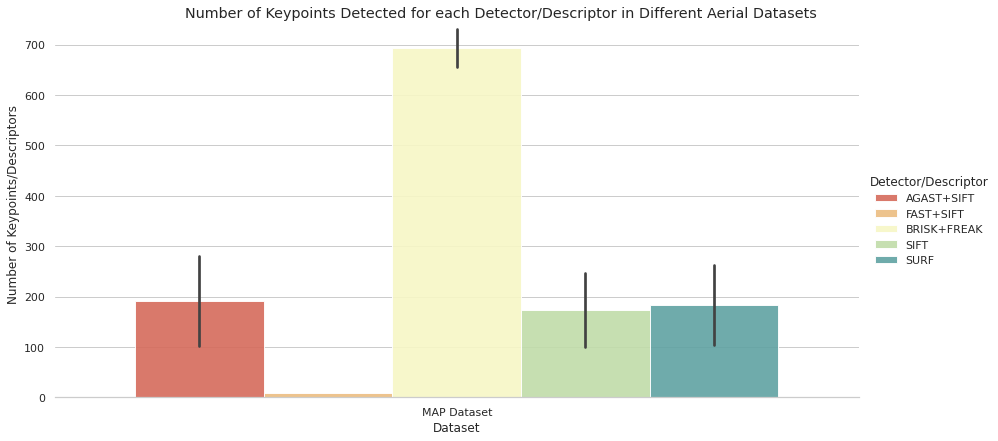

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [ ]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [ ]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

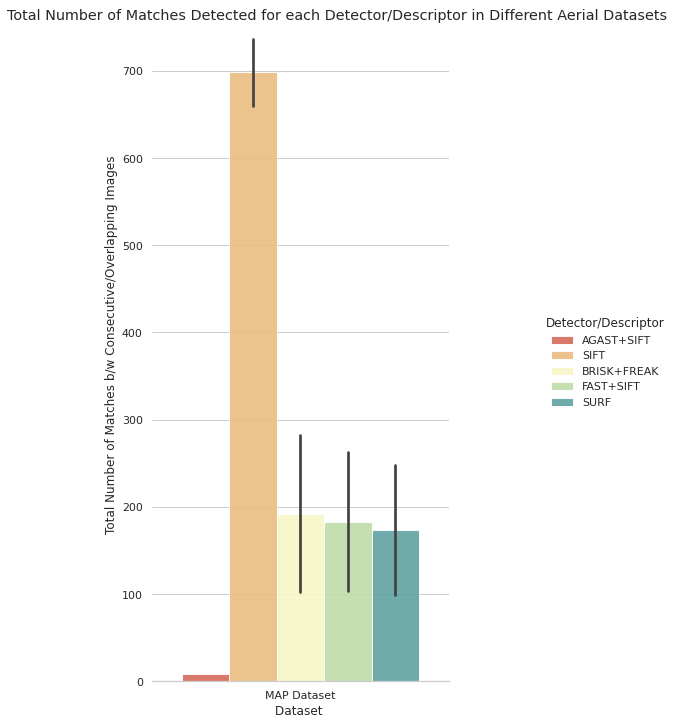

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [ ]:
df_match_5['Number of Good Matches'] =  num_good_matches_sift + num_good_matches_surf + num_good_matches_freak + num_good_matches_agast + num_good_matches_fast
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

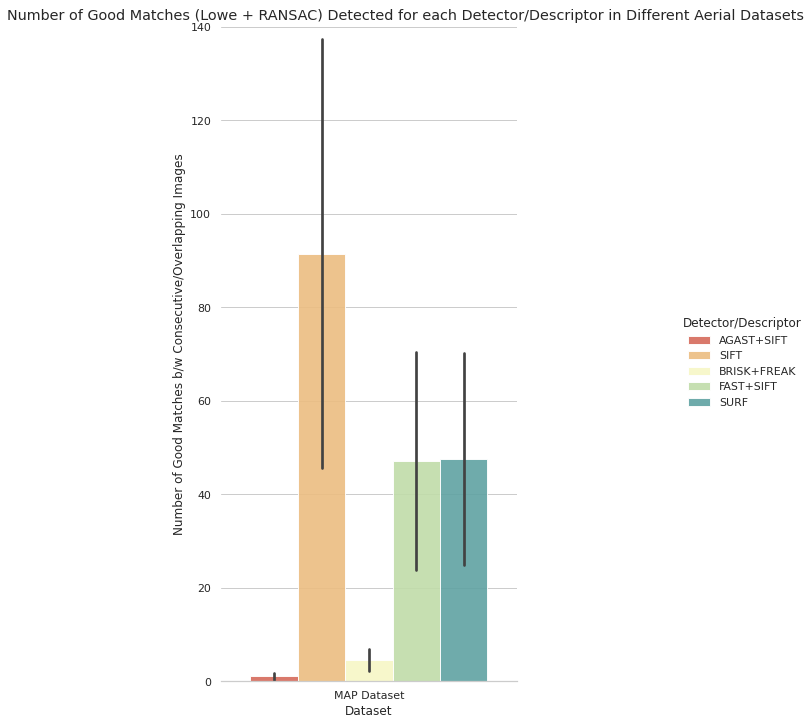

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_7.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [ ]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

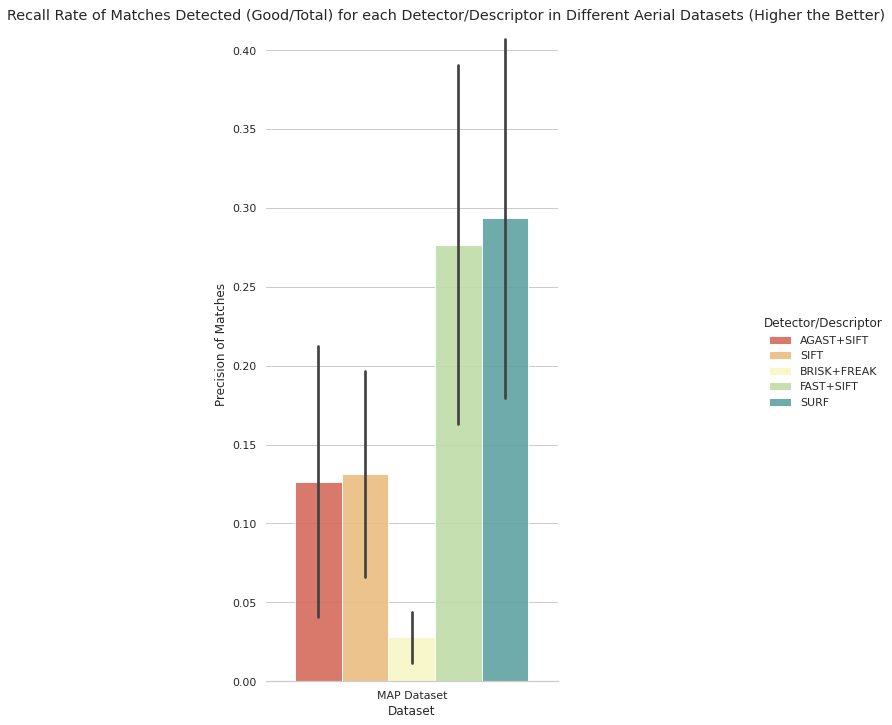

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_7.png')

1-Precision Rate for each Detector+Descriptor

In [ ]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

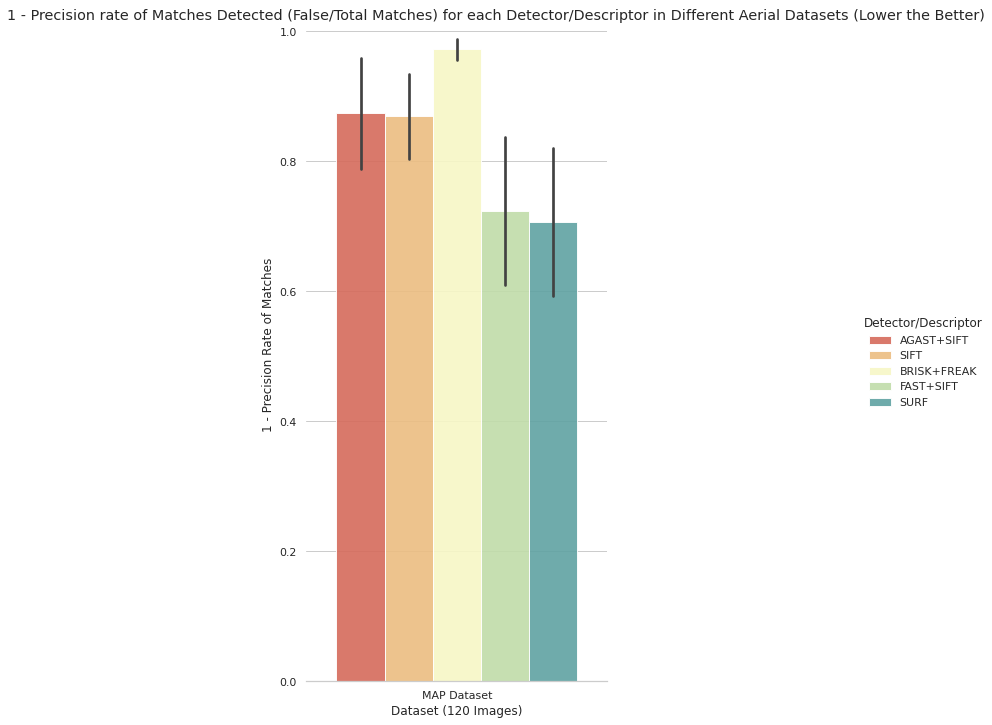

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_7.png')

F-Score for each Detector+Descriptor

In [ ]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

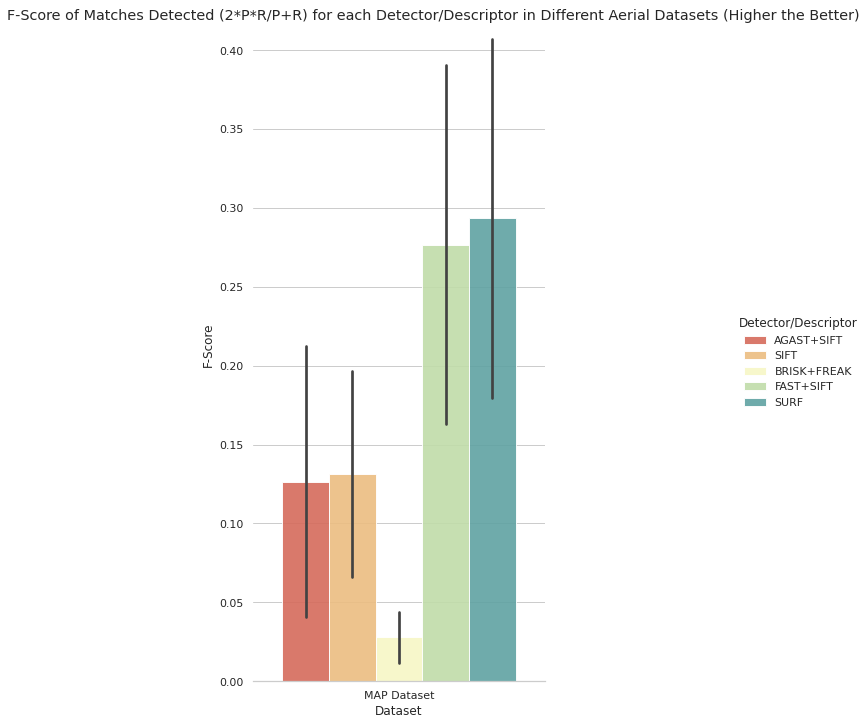

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_7.png')

In [ ]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [ ]:
print(df_time_5)

       Dataset        Time Detector/Descriptor
0  MAP Dataset  380.126910          AGAST+SIFT
1  MAP Dataset   95.590266           FAST+SIFT
2  MAP Dataset  236.915398         BRISK+FREAK
3  MAP Dataset  254.300139                SURF
4  MAP Dataset  669.237564                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

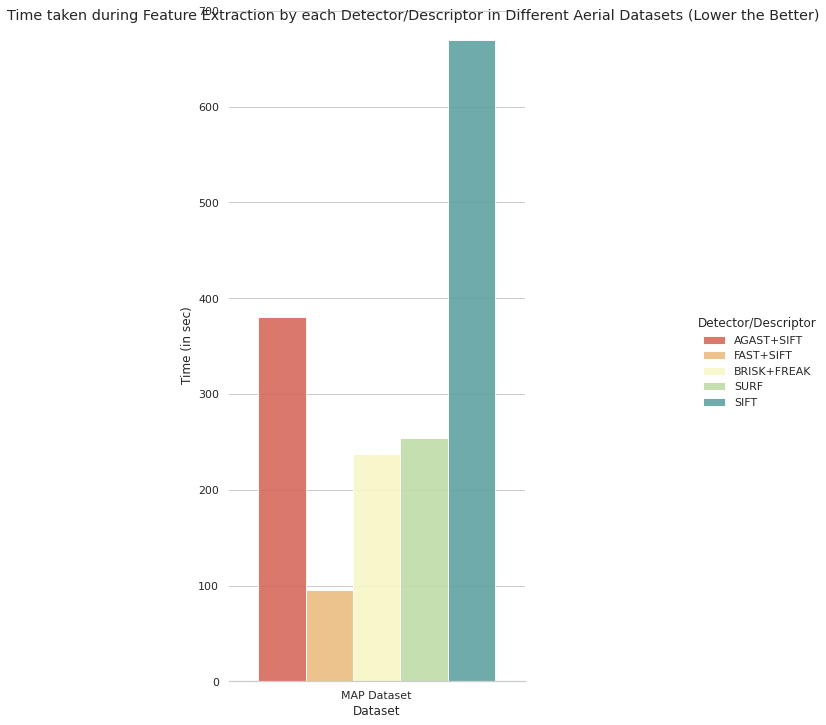

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_7.png')

In [ ]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU